# Toybox-360 100 epochs

In [ ]:
import os
os.chdir("/content/drive/MyDrive/ug-project/src")
!pwd
%load_ext autoreload
%autoreload 2

/content/drive/MyDrive/ug-project/src


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import torchvision.transforms.v2 as v2
from datasets import ToyboxDatasetInstances, TOYBOX_MEAN, TOYBOX_STD
from torch.utils.data import DataLoader

### Set hyperparameters

In [ ]:
learning_rate = 0.001
epochs = 100
batch_size = 256
output_dir_clear = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/toybox360_clear_100_epochs"
output_dir_blur = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/toybox360_blur_100_epochs"

os.makedirs(output_dir_clear, exist_ok=True)
os.makedirs(output_dir_blur, exist_ok=True)

### Define transforms

In [ ]:
rng = np.random.default_rng(seed=5)

prob = 0.2
color_transforms = [v2.RandomApply([v2.ColorJitter(brightness=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(hue=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(saturation=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(contrast=0.2)], p=prob),
                    v2.RandomEqualize(p=prob),
                    v2.RandomPosterize(bits=4, p=prob),
                    v2.RandomAutocontrast(p=prob)
                    ]
transform = v2.Compose([v2.ToPILImage(),
                        v2.Resize((256, 256)),
                        v2.RandomResizedCrop(size=224, scale=(0.5, 1.0), interpolation=v2.InterpolationMode.BICUBIC),
                        v2.RandomOrder(color_transforms),
                        v2.RandomHorizontalFlip(),
                        v2.ToTensor(),
                        v2.Normalize(mean=TOYBOX_MEAN, std=TOYBOX_STD),
                        v2.RandomErasing(p=0.5)
                        ])
transform_test = v2.Compose([
    v2.ToPILImage(),
    v2.Resize(224),
    v2.ToTensor(),
    v2.Normalize(mean=TOYBOX_MEAN, std=TOYBOX_STD)
])

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


### Load Toybox 360 dataset

In [ ]:
train_dataset = ToyboxDatasetInstances(rng=rng, train=True, hypertune=True, transform=transform)
print(f"Dev set size: {len(train_dataset)}")

val_dataset = ToyboxDatasetInstances(rng=rng, train=False, hypertune=True, transform=transform_test)
print(f"Val set size: {len(val_dataset)}")

test_dataset = ToyboxDatasetInstances(rng=rng, train=False, hypertune=False, transform=transform_test)
print(f"Test set size: {len(test_dataset)}")


train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)

Dev set size: 133644
Val set size: 2820
Test set size: 2820


### Create AlexNet model

In [ ]:
import torch
import torch.nn as nn
from model import AlexNetSup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

clear_model = AlexNetSup(num_classes=360).to(device)
blur_model = AlexNetSup(num_classes=360).to(device)

criterion = nn.CrossEntropyLoss()
clear_optimizer = torch.optim.Adam(clear_model.parameters(), lr=learning_rate, weight_decay=1e-5)
blur_optimizer = torch.optim.Adam(blur_model.parameters(), lr=learning_rate, weight_decay=1e-5)
steps = len(train_loader)
clear_warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=clear_optimizer, start_factor=0.01, end_factor=1.0,
                                                      total_iters=2*steps)
clear_decay_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=clear_optimizer, T_max=(epochs - 2) * steps)
clear_combined_scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer=clear_optimizer,
                                                            schedulers=[clear_warmup_scheduler, clear_decay_scheduler],
                                                            milestones=[2*steps+1])
blur_warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=blur_optimizer, start_factor=0.01, end_factor=1.0,
                                                      total_iters=2*steps)
blur_decay_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=blur_optimizer, T_max=(epochs - 2) * steps)
blur_combined_scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer=blur_optimizer,
                                                            schedulers=[blur_warmup_scheduler, blur_decay_scheduler],
                                                            milestones=[2*steps+1])

### Evaluate model before training

In [ ]:
!pip install kornia

In [ ]:
from utils import add_blur_with

# Initialize metrics for plotting
clear_train_correct, clear_val_correct = [], []
blur_train_correct, blur_val_correct = [], []
clear_train_loss_list, clear_val_loss_list = [], []
blur_train_loss_list, blur_val_loss_list = [], []
logs_clear = []
logs_blur = []

clear_model.eval()
blur_model.eval()

# Training metrics initialization
clear_train_corr, blur_train_corr, total_train = 0, 0, 0
clear_train_loss, blur_train_loss = 0.0, 0.0

with torch.no_grad():
    for _, images, labels in train_loader:
        # Apply blur transformation
        images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        images, labels = images.to(device), labels.to(device)

        # Get predictions from both models
        clear_y_pred = clear_model(images)
        blur_y_pred = blur_model(images)

        # Calculate loss values
        clear_loss = criterion(clear_y_pred, labels)
        blur_loss = criterion(blur_y_pred, labels)

        # Accumulate total loss weighted by batch size
        clear_train_loss += clear_loss.item() * labels.size(0)
        blur_train_loss += blur_loss.item() * labels.size(0)

        # Compute accuracy for current batch
        clear_predicted = torch.max(clear_y_pred.data, 1)[1]
        blur_predicted = torch.max(blur_y_pred.data, 1)[1]
        clear_train_corr += (clear_predicted == labels).sum().item()
        blur_train_corr += (blur_predicted == labels).sum().item()
        total_train += labels.size(0)

# Average accuracy and loss over all training samples
clear_train_accuracy = (clear_train_corr / total_train) * 100
blur_train_accuracy = (blur_train_corr / total_train) * 100
clear_train_loss /= total_train
blur_train_loss /= total_train

# Validation metrics initialization
clear_val_corr, blur_val_corr, total_val = 0, 0, 0
clear_val_loss, blur_val_loss = 0.0, 0.0

with torch.no_grad():
    for _, images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        # Get predictions from both models on validation data
        clear_y_val_pred = clear_model(images)
        blur_y_val_pred = blur_model(images)

        # Calculate loss values for validation set
        clear_loss = criterion(clear_y_val_pred, labels)
        blur_loss = criterion(blur_y_val_pred, labels)

        # Accumulate total loss weighted by batch size
        clear_val_loss += clear_loss.item() * labels.size(0)
        blur_val_loss += blur_loss.item() * labels.size(0)

        # Compute accuracy for current batch
        clear_predicted = torch.max(clear_y_val_pred.data, 1)[1]
        blur_predicted = torch.max(blur_y_val_pred.data, 1)[1]
        clear_val_corr += (clear_predicted == labels).sum().item()
        blur_val_corr += (blur_predicted == labels).sum().item()
        total_val += labels.size(0)

# Average accuracy and loss over all validation samples
clear_val_accuracy = (clear_val_corr / total_val) * 100
blur_val_accuracy = (blur_val_corr / total_val) * 100
clear_val_loss /= total_val
blur_val_loss /= total_val

# Save results for plotting
clear_train_correct.append(clear_train_accuracy)
clear_val_correct.append(clear_val_accuracy)
blur_train_correct.append(blur_train_accuracy)
blur_val_correct.append(blur_val_accuracy)
clear_train_loss_list.append(clear_train_loss)
blur_train_loss_list.append(blur_train_loss)
clear_val_loss_list.append(clear_val_loss)
blur_val_loss_list.append(blur_val_loss)

# Log entry with both accuracy and loss values
clear_log_entry = (f"Epoch 0/{epochs}, Clear train acc: {clear_train_accuracy:.4f}%, Clear train loss: {clear_train_loss:.4f}, Clear val acc: {clear_val_accuracy:.2f}%, Clear val loss: {clear_val_loss:.4f}")
print(clear_log_entry)
logs_clear.append(clear_log_entry)

blur_log_entry = (f"Epoch 0/{epochs}, Blur train acc: {blur_train_accuracy:.4f}%, Blur train loss: {blur_train_loss:.4f}, Blur val acc: {blur_val_accuracy:.2f}%, Blur val loss: {blur_val_loss:.4f}")
print(blur_log_entry)
logs_blur.append(blur_log_entry)

Epoch 0/100, Clear train acc: 0.2312%, Clear train loss: 5.8905, Clear val acc: 0.18%, Clear val loss: 5.8957
Epoch 0/100, Blur train acc: 0.2896%, Blur train loss: 5.8889, Blur val acc: 0.32%, Blur val loss: 5.8912


### Training loop

In [ ]:
for epoch in range(0, 20):

    ###################### Train model #########################
    clear_model.train()
    blur_model.train()
    # Initialize accumulators for training loss and sample count
    clear_train_loss_sum, blur_train_loss_sum = 0.0, 0.0
    train_samples = 0

    for _, images, labels in train_loader:

        # Apply blur sigma depending on training stage
        if epoch < 20:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        elif epoch < 40:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 1, 0])
        elif epoch < 60:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 1, 0, 0])
        elif epoch < 80:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 1, 0, 0, 0])
        else:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [1, 0, 0, 0, 0])

        blurred_images, labels = blurred_images.to(device), labels.to(device)
        images = images.to(device)

        # Zero the parameter gradients
        clear_optimizer.zero_grad()
        blur_optimizer.zero_grad()

        # Forward passes
        clear_logits = clear_model(images)
        blur_logits = blur_model(blurred_images)

        # Compute losses
        clear_loss = criterion(clear_logits, labels)
        blur_loss = criterion(blur_logits, labels)

        # Backward passes and optimizer steps
        clear_loss.backward()
        blur_loss.backward()
        clear_optimizer.step()
        blur_optimizer.step()
        clear_combined_scheduler.step()
        blur_combined_scheduler.step()

        # Accumulate training loss (weighted by batch size)
        batch_size = labels.size(0)
        clear_train_loss_sum += clear_loss.item() * batch_size
        blur_train_loss_sum += blur_loss.item() * batch_size
        train_samples += batch_size

    # Compute average training loss over all batches for the training loop
    clear_train_loss_epoch = clear_train_loss_sum / train_samples
    blur_train_loss_epoch = blur_train_loss_sum / train_samples

    ###################### Evaluate on Training Set ######################
    clear_model.eval()
    blur_model.eval()
    clear_train_corr, blur_train_corr, total_train = 0, 0, 0
    clear_train_loss_eval, blur_train_loss_eval = 0.0, 0.0

    with torch.no_grad():
        for _, images, labels in train_loader:
            if epoch < 20:
                blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
            elif epoch < 40:
                blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 1, 0])
            elif epoch < 60:
                blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 1, 0, 0])
            elif epoch < 80:
                blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 1, 0, 0, 0])
            else:
                blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [1, 0, 0, 0, 0])
            blurred_images, labels = blurred_images.to(device), labels.to(device)
            images = images.to(device)

            clear_y_pred = clear_model(images)
            blur_y_pred = blur_model(blurred_images)

            # Calculate loss on the training set (evaluation mode)
            clear_loss_eval = criterion(clear_y_pred, labels)
            blur_loss_eval = criterion(blur_y_pred, labels)
            batch_size = labels.size(0)
            clear_train_loss_eval += clear_loss_eval.item() * batch_size
            blur_train_loss_eval += blur_loss_eval.item() * batch_size

            # Compute predictions for accuracy
            clear_predicted = torch.max(clear_y_pred.data, 1)[1]
            blur_predicted = torch.max(blur_y_pred.data, 1)[1]
            clear_train_corr += (clear_predicted == labels).sum().item()
            blur_train_corr += (blur_predicted == labels).sum().item()
            total_train += batch_size

    clear_train_accuracy = (clear_train_corr / total_train) * 100
    blur_train_accuracy = (blur_train_corr / total_train) * 100
    clear_train_loss_avg = clear_train_loss_eval / total_train
    blur_train_loss_avg = blur_train_loss_eval / total_train

    ###################### Evaluate on Validation Set ######################
    clear_val_corr, blur_val_corr, total_val = 0, 0, 0
    clear_val_loss_sum, blur_val_loss_sum = 0.0, 0.0

    with torch.no_grad():
        for _, images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            clear_y_pred = clear_model(images)
            blur_y_pred = blur_model(images)

            # Compute validation losses
            clear_loss_val = criterion(clear_y_pred, labels)
            blur_loss_val = criterion(blur_y_pred, labels)
            batch_size = labels.size(0)
            clear_val_loss_sum += clear_loss_val.item() * batch_size
            blur_val_loss_sum += blur_loss_val.item() * batch_size

            # Compute predictions for accuracy
            clear_predicted = torch.max(clear_y_pred.data, 1)[1]
            blur_predicted = torch.max(blur_y_pred.data, 1)[1]
            clear_val_corr += (clear_predicted == labels).sum().item()
            blur_val_corr += (blur_predicted == labels).sum().item()
            total_val += batch_size

    clear_val_accuracy = (clear_val_corr / total_val) * 100
    blur_val_accuracy = (blur_val_corr / total_val) * 100
    clear_val_loss_avg = clear_val_loss_sum / total_val
    blur_val_loss_avg = blur_val_loss_sum / total_val

    # Append losses to loss lists for plotting
    clear_train_loss_list.append(clear_train_loss_avg)
    blur_train_loss_list.append(blur_train_loss_avg)
    clear_val_loss_list.append(clear_val_loss_avg)
    blur_val_loss_list.append(blur_val_loss_avg)

    # Save accuracy metrics for plotting (accuracy lists defined earlier)
    clear_train_correct.append(clear_train_accuracy)
    clear_val_correct.append(clear_val_accuracy)
    blur_train_correct.append(blur_train_accuracy)
    blur_val_correct.append(blur_val_accuracy)

    clear_log_entry = (f"Epoch {epoch+1}/{epochs}, Clear train acc: {clear_train_accuracy:.4f}%, Clear train loss: {clear_train_loss_avg:.4f}, Clear val acc: {clear_val_accuracy:.2f}%, Clear val loss: {clear_val_loss_avg:.4f}")
    print(clear_log_entry)
    logs_clear.append(clear_log_entry)

    blur_log_entry = (f"Epoch {epoch+1}/{epochs}, Blur train acc: {blur_train_accuracy:.4f}%, Blur train loss: {blur_train_loss_avg:.4f}, Blur val acc: {blur_val_accuracy:.2f}%, Blur val loss: {blur_val_loss_avg:.4f}")
    print(blur_log_entry)
    logs_blur.append(blur_log_entry)

    ###################### Save Checkpoints ######################
    if (epoch+1) % 10 == 0:
        clear_checkpoint_path = os.path.join(output_dir_clear, f'model_checkpoint_epoch{epoch+1}.pth')
        checkpoint_clear = {
            'epoch': epoch+1,
            'model_state_dict': clear_model.state_dict(),
            'optimizer_state_dict': clear_optimizer.state_dict(),
            'train_accuracy': clear_train_accuracy,
            'train_loss': clear_train_loss_epoch,  # Optionally log training loss from the training loop
        }
        torch.save(checkpoint_clear, clear_checkpoint_path)

        blur_checkpoint_path = os.path.join(output_dir_blur, f'model_checkpoint_epoch{epoch+1}.pth')
        checkpoint_blur = {
            'epoch': epoch+1,
            'model_state_dict': blur_model.state_dict(),
            'optimizer_state_dict': blur_optimizer.state_dict(),
            'train_accuracy': blur_train_accuracy,
            'train_loss': blur_train_loss_epoch,
        }
        torch.save(checkpoint_blur, blur_checkpoint_path)

Epoch 1/100, Clear train acc: 58.5608%, Clear train loss: 1.7444, Clear val acc: 54.47%, Clear val loss: 1.9671
Epoch 1/100, Blur train acc: 48.4502%, Blur train loss: 2.2225, Blur val acc: 34.23%, Blur val loss: 3.3474
Epoch 2/100, Clear train acc: 77.4852%, Clear train loss: 0.8722, Clear val acc: 70.24%, Clear val loss: 1.3283
Epoch 2/100, Blur train acc: 70.0326%, Blur train loss: 1.1959, Blur val acc: 32.28%, Blur val loss: 4.2390
Epoch 3/100, Clear train acc: 83.7950%, Clear train loss: 0.6108, Clear val acc: 73.72%, Clear val loss: 1.1387
Epoch 3/100, Blur train acc: 78.9751%, Blur train loss: 0.8236, Blur val acc: 37.46%, Blur val loss: 4.5223
Epoch 4/100, Clear train acc: 85.8163%, Clear train loss: 0.5360, Clear val acc: 76.81%, Clear val loss: 1.1596
Epoch 4/100, Blur train acc: 81.6272%, Blur train loss: 0.7115, Blur val acc: 28.05%, Blur val loss: 5.5786
Epoch 5/100, Clear train acc: 88.2304%, Clear train loss: 0.4311, Clear val acc: 78.34%, Clear val loss: 0.9779
Epoch 5/

## Resume training

In [ ]:
import re

text = """
Epoch 1/100, Clear train acc: 59.7581%, Clear train loss: 1.6819, Clear val acc: 54.58%, Clear val loss: 2.0026
Epoch 1/100, Blur train acc: 51.6792%, Blur train loss: 2.0869, Blur val acc: 43.61%, Blur val loss: 2.7180
Epoch 2/100, Clear train acc: 77.5226%, Clear train loss: 0.8802, Clear val acc: 70.81%, Clear val loss: 1.2684
Epoch 2/100, Blur train acc: 69.9840%, Blur train loss: 1.2180, Blur val acc: 45.95%, Blur val loss: 2.9895
Epoch 3/100, Clear train acc: 83.9088%, Clear train loss: 0.6035, Clear val acc: 72.80%, Clear val loss: 1.1964
Epoch 3/100, Blur train acc: 78.2133%, Blur train loss: 0.8398, Blur val acc: 33.38%, Blur val loss: 4.9890
Epoch 4/100, Clear train acc: 87.4701%, Clear train loss: 0.4631, Clear val acc: 75.21%, Clear val loss: 1.0536
Epoch 4/100, Blur train acc: 83.1575%, Blur train loss: 0.6419, Blur val acc: 35.12%, Blur val loss: 4.5278
Epoch 5/100, Clear train acc: 87.9804%, Clear train loss: 0.4365, Clear val acc: 75.53%, Clear val loss: 1.0988
Epoch 5/100, Blur train acc: 84.5411%, Blur train loss: 0.5816, Blur val acc: 26.78%, Blur val loss: 6.4402
Epoch 6/100, Clear train acc: 89.8527%, Clear train loss: 0.3697, Clear val acc: 78.62%, Clear val loss: 1.0522
Epoch 6/100, Blur train acc: 84.5299%, Blur train loss: 0.5740, Blur val acc: 23.58%, Blur val loss: 7.5664
Epoch 7/100, Clear train acc: 90.5330%, Clear train loss: 0.3435, Clear val acc: 79.37%, Clear val loss: 1.0167
Epoch 7/100, Blur train acc: 86.5279%, Blur train loss: 0.4975, Blur val acc: 25.32%, Blur val loss: 7.9527
Epoch 8/100, Clear train acc: 89.3506%, Clear train loss: 0.3921, Clear val acc: 77.81%, Clear val loss: 1.0896
Epoch 8/100, Blur train acc: 86.2009%, Blur train loss: 0.5216, Blur val acc: 26.14%, Blur val loss: 7.2544
Epoch 9/100, Clear train acc: 91.0283%, Clear train loss: 0.3281, Clear val acc: 82.07%, Clear val loss: 0.8844
Epoch 9/100, Blur train acc: 87.7903%, Blur train loss: 0.4481, Blur val acc: 21.20%, Blur val loss: 8.2491
Epoch 10/100, Clear train acc: 88.7130%, Clear train loss: 0.4194, Clear val acc: 74.61%, Clear val loss: 1.2785
Epoch 10/100, Blur train acc: 87.9520%, Blur train loss: 0.4510, Blur val acc: 22.66%, Blur val loss: 9.8711
Epoch 11/100, Clear train acc: 91.7954%, Clear train loss: 0.3009, Clear val acc: 80.79%, Clear val loss: 0.9372
Epoch 11/100, Blur train acc: 87.9033%, Blur train loss: 0.4487, Blur val acc: 21.66%, Blur val loss: 9.1033
Epoch 12/100, Clear train acc: 91.3396%, Clear train loss: 0.3114, Clear val acc: 78.62%, Clear val loss: 0.9902
Epoch 12/100, Blur train acc: 87.8495%, Blur train loss: 0.4533, Blur val acc: 25.60%, Blur val loss: 8.1421
Epoch 13/100, Clear train acc: 91.4130%, Clear train loss: 0.3094, Clear val acc: 79.83%, Clear val loss: 0.9697
Epoch 13/100, Blur train acc: 88.4676%, Blur train loss: 0.4264, Blur val acc: 19.57%, Blur val loss: 10.4238
Epoch 14/100, Clear train acc: 91.7161%, Clear train loss: 0.2994, Clear val acc: 79.08%, Clear val loss: 0.9805
Epoch 14/100, Blur train acc: 88.8567%, Blur train loss: 0.4199, Blur val acc: 24.93%, Blur val loss: 9.1765
Epoch 15/100, Clear train acc: 91.7467%, Clear train loss: 0.3006, Clear val acc: 80.54%, Clear val loss: 0.9116
Epoch 15/100, Blur train acc: 89.0543%, Blur train loss: 0.4046, Blur val acc: 26.78%, Blur val loss: 8.4667
Epoch 16/100, Clear train acc: 92.1246%, Clear train loss: 0.2905, Clear val acc: 80.75%, Clear val loss: 0.9494
Epoch 16/100, Blur train acc: 90.7792%, Blur train loss: 0.3429, Blur val acc: 21.27%, Blur val loss: 9.7198
Epoch 17/100, Clear train acc: 92.4053%, Clear train loss: 0.2774, Clear val acc: 80.08%, Clear val loss: 0.9800
Epoch 17/100, Blur train acc: 90.2441%, Blur train loss: 0.3582, Blur val acc: 24.47%, Blur val loss: 9.2892
Epoch 18/100, Clear train acc: 92.3895%, Clear train loss: 0.2823, Clear val acc: 80.15%, Clear val loss: 0.9638
Epoch 18/100, Blur train acc: 90.1393%, Blur train loss: 0.3629, Blur val acc: 23.30%, Blur val loss: 9.8054
Epoch 19/100, Clear train acc: 92.4322%, Clear train loss: 0.2771, Clear val acc: 78.84%, Clear val loss: 1.0170
Epoch 19/100, Blur train acc: 90.8398%, Blur train loss: 0.3360, Blur val acc: 14.38%, Blur val loss: 13.1037
Epoch 20/100, Clear train acc: 92.8064%, Clear train loss: 0.2732, Clear val acc: 79.97%, Clear val loss: 1.1318
Epoch 20/100, Blur train acc: 90.8630%, Blur train loss: 0.3349, Blur val acc: 18.75%, Blur val loss: 11.1658
Epoch 21/100, Clear train acc: 93.3534%, Clear train loss: 0.2389, Clear val acc: 81.92%, Clear val loss: 0.9051
Epoch 21/100, Blur train acc: 91.3179%, Blur train loss: 0.3241, Blur val acc: 67.15%, Blur val loss: 1.7209
Epoch 22/100, Clear train acc: 93.4080%, Clear train loss: 0.2371, Clear val acc: 81.36%, Clear val loss: 0.9221
Epoch 22/100, Blur train acc: 90.9640%, Blur train loss: 0.3338, Blur val acc: 66.44%, Blur val loss: 1.8594
Epoch 23/100, Clear train acc: 93.2606%, Clear train loss: 0.2467, Clear val acc: 80.50%, Clear val loss: 0.9427
Epoch 23/100, Blur train acc: 91.8934%, Blur train loss: 0.2940, Blur val acc: 69.00%, Blur val loss: 1.6670
Epoch 24/100, Clear train acc: 93.9693%, Clear train loss: 0.2198, Clear val acc: 80.50%, Clear val loss: 1.0099
Epoch 24/100, Blur train acc: 92.5519%, Blur train loss: 0.2724, Blur val acc: 67.08%, Blur val loss: 1.8818
Epoch 25/100, Clear train acc: 93.8061%, Clear train loss: 0.2264, Clear val acc: 81.78%, Clear val loss: 0.9031
Epoch 25/100, Blur train acc: 91.3703%, Blur train loss: 0.3138, Blur val acc: 64.67%, Blur val loss: 1.8892
Epoch 26/100, Clear train acc: 93.2254%, Clear train loss: 0.2473, Clear val acc: 80.65%, Clear val loss: 0.9942
Epoch 26/100, Blur train acc: 92.1897%, Blur train loss: 0.2839, Blur val acc: 62.25%, Blur val loss: 2.0396
Epoch 27/100, Clear train acc: 94.1152%, Clear train loss: 0.2147, Clear val acc: 81.50%, Clear val loss: 0.9614
Epoch 27/100, Blur train acc: 92.4187%, Blur train loss: 0.2816, Blur val acc: 68.43%, Blur val loss: 1.8126
Epoch 28/100, Clear train acc: 93.8555%, Clear train loss: 0.2210, Clear val acc: 81.36%, Clear val loss: 0.9560
Epoch 28/100, Blur train acc: 92.5961%, Blur train loss: 0.2708, Blur val acc: 65.41%, Blur val loss: 1.9659
Epoch 29/100, Clear train acc: 93.3803%, Clear train loss: 0.2379, Clear val acc: 80.08%, Clear val loss: 0.9861
Epoch 29/100, Blur train acc: 92.8071%, Blur train loss: 0.2668, Blur val acc: 59.84%, Blur val loss: 2.4567
Epoch 30/100, Clear train acc: 94.3068%, Clear train loss: 0.2117, Clear val acc: 81.39%, Clear val loss: 0.9814
Epoch 30/100, Blur train acc: 93.2801%, Blur train loss: 0.2428, Blur val acc: 63.28%, Blur val loss: 2.0766
Epoch 31/100, Clear train acc: 94.3861%, Clear train loss: 0.2015, Clear val acc: 80.75%, Clear val loss: 0.9873
Epoch 31/100, Blur train acc: 93.1251%, Blur train loss: 0.2495, Blur val acc: 63.14%, Blur val loss: 2.0260
Epoch 32/100, Clear train acc: 94.7108%, Clear train loss: 0.1929, Clear val acc: 81.92%, Clear val loss: 1.0164
Epoch 32/100, Blur train acc: 92.8079%, Blur train loss: 0.2617, Blur val acc: 62.25%, Blur val loss: 2.1775
Epoch 33/100, Clear train acc: 93.8675%, Clear train loss: 0.2263, Clear val acc: 81.18%, Clear val loss: 1.0698
Epoch 33/100, Blur train acc: 93.5487%, Blur train loss: 0.2369, Blur val acc: 63.39%, Blur val loss: 2.1027
Epoch 34/100, Clear train acc: 94.3569%, Clear train loss: 0.2012, Clear val acc: 81.29%, Clear val loss: 0.9296
Epoch 34/100, Blur train acc: 93.9341%, Blur train loss: 0.2229, Blur val acc: 57.88%, Blur val loss: 2.5604
Epoch 35/100, Clear train acc: 94.4587%, Clear train loss: 0.2009, Clear val acc: 81.14%, Clear val loss: 0.9585
Epoch 35/100, Blur train acc: 93.4133%, Blur train loss: 0.2363, Blur val acc: 63.57%, Blur val loss: 2.2201
Epoch 36/100, Clear train acc: 94.8164%, Clear train loss: 0.1859, Clear val acc: 82.14%, Clear val loss: 0.9489
Epoch 36/100, Blur train acc: 94.1736%, Blur train loss: 0.2119, Blur val acc: 60.94%, Blur val loss: 2.2400
Epoch 37/100, Clear train acc: 94.7438%, Clear train loss: 0.1891, Clear val acc: 82.63%, Clear val loss: 0.8271
Epoch 37/100, Blur train acc: 94.4257%, Blur train loss: 0.2035, Blur val acc: 60.48%, Blur val loss: 2.3691
Epoch 38/100, Clear train acc: 94.7640%, Clear train loss: 0.1897, Clear val acc: 81.11%, Clear val loss: 0.9354
Epoch 38/100, Blur train acc: 94.5230%, Blur train loss: 0.2030, Blur val acc: 57.42%, Blur val loss: 2.7512
Epoch 39/100, Clear train acc: 95.1307%, Clear train loss: 0.1752, Clear val acc: 81.64%, Clear val loss: 0.9716
Epoch 39/100, Blur train acc: 94.0276%, Blur train loss: 0.2197, Blur val acc: 53.66%, Blur val loss: 3.1581
Epoch 40/100, Clear train acc: 95.3806%, Clear train loss: 0.1734, Clear val acc: 81.68%, Clear val loss: 0.9792
Epoch 40/100, Blur train acc: 94.7056%, Blur train loss: 0.1872, Blur val acc: 56.57%, Blur val loss: 2.7538
Epoch 41/100, Clear train acc: 95.5841%, Clear train loss: 0.1571, Clear val acc: 83.35%, Clear val loss: 0.9004
Epoch 41/100, Blur train acc: 94.3928%, Blur train loss: 0.2021, Blur val acc: 79.40%, Blur val loss: 0.9857
Epoch 42/100, Clear train acc: 95.5714%, Clear train loss: 0.1601, Clear val acc: 82.42%, Clear val loss: 0.9101
Epoch 42/100, Blur train acc: 95.1613%, Blur train loss: 0.1753, Blur val acc: 80.43%, Blur val loss: 0.9583
Epoch 43/100, Clear train acc: 95.6021%, Clear train loss: 0.1564, Clear val acc: 84.02%, Clear val loss: 0.8437
Epoch 43/100, Blur train acc: 94.9855%, Blur train loss: 0.1819, Blur val acc: 81.53%, Blur val loss: 0.9129
Epoch 44/100, Clear train acc: 95.8872%, Clear train loss: 0.1476, Clear val acc: 83.03%, Clear val loss: 0.8887
Epoch 44/100, Blur train acc: 95.0783%, Blur train loss: 0.1749, Blur val acc: 81.29%, Blur val loss: 0.9206
Epoch 45/100, Clear train acc: 96.1544%, Clear train loss: 0.1382, Clear val acc: 83.59%, Clear val loss: 0.8963
Epoch 45/100, Blur train acc: 95.4135%, Blur train loss: 0.1629, Blur val acc: 81.82%, Blur val loss: 0.8490
Epoch 46/100, Clear train acc: 96.0713%, Clear train loss: 0.1416, Clear val acc: 84.13%, Clear val loss: 0.8299
Epoch 46/100, Blur train acc: 95.0888%, Blur train loss: 0.1788, Blur val acc: 79.97%, Blur val loss: 1.0131
Epoch 47/100, Clear train acc: 96.3804%, Clear train loss: 0.1313, Clear val acc: 84.06%, Clear val loss: 0.8795
Epoch 47/100, Blur train acc: 95.5797%, Blur train loss: 0.1592, Blur val acc: 83.31%, Blur val loss: 0.8940
Epoch 48/100, Clear train acc: 96.3235%, Clear train loss: 0.1308, Clear val acc: 84.34%, Clear val loss: 0.8710
Epoch 48/100, Blur train acc: 95.5864%, Blur train loss: 0.1609, Blur val acc: 83.27%, Blur val loss: 0.8238
Epoch 49/100, Clear train acc: 96.5368%, Clear train loss: 0.1265, Clear val acc: 83.88%, Clear val loss: 0.8317
Epoch 49/100, Blur train acc: 95.8812%, Blur train loss: 0.1496, Blur val acc: 80.75%, Blur val loss: 0.9995
Epoch 50/100, Clear train acc: 96.6408%, Clear train loss: 0.1191, Clear val acc: 84.94%, Clear val loss: 0.8377
Epoch 50/100, Blur train acc: 95.9231%, Blur train loss: 0.1445, Blur val acc: 81.32%, Blur val loss: 0.9272
Epoch 51/100, Clear train acc: 96.8915%, Clear train loss: 0.1118, Clear val acc: 85.05%, Clear val loss: 0.8289
Epoch 51/100, Blur train acc: 96.2756%, Blur train loss: 0.1352, Blur val acc: 80.86%, Blur val loss: 1.0385
Epoch 52/100, Clear train acc: 96.8757%, Clear train loss: 0.1129, Clear val acc: 84.34%, Clear val loss: 0.8430
Epoch 52/100, Blur train acc: 96.2831%, Blur train loss: 0.1348, Blur val acc: 81.78%, Blur val loss: 0.9446
Epoch 53/100, Clear train acc: 96.7321%, Clear train loss: 0.1173, Clear val acc: 83.77%, Clear val loss: 0.8483
Epoch 53/100, Blur train acc: 96.2075%, Blur train loss: 0.1346, Blur val acc: 82.81%, Blur val loss: 0.8865
Epoch 54/100, Clear train acc: 96.9162%, Clear train loss: 0.1086, Clear val acc: 85.09%, Clear val loss: 0.8306
Epoch 54/100, Blur train acc: 96.4799%, Blur train loss: 0.1227, Blur val acc: 82.85%, Blur val loss: 0.8627
Epoch 55/100, Clear train acc: 96.7837%, Clear train loss: 0.1138, Clear val acc: 85.01%, Clear val loss: 0.7935
Epoch 55/100, Blur train acc: 96.5884%, Blur train loss: 0.1220, Blur val acc: 82.99%, Blur val loss: 0.9275
Epoch 56/100, Clear train acc: 97.1676%, Clear train loss: 0.1008, Clear val acc: 84.87%, Clear val loss: 0.7951
Epoch 56/100, Blur train acc: 96.8241%, Blur train loss: 0.1124, Blur val acc: 83.66%, Blur val loss: 0.9016
Epoch 57/100, Clear train acc: 97.1242%, Clear train loss: 0.1025, Clear val acc: 85.19%, Clear val loss: 0.8369
Epoch 57/100, Blur train acc: 96.7433%, Blur train loss: 0.1169, Blur val acc: 79.83%, Blur val loss: 1.1069
Epoch 58/100, Clear train acc: 97.2986%, Clear train loss: 0.0937, Clear val acc: 85.65%, Clear val loss: 0.7762
Epoch 58/100, Blur train acc: 96.8256%, Blur train loss: 0.1124, Blur val acc: 81.89%, Blur val loss: 0.9157
Epoch 59/100, Clear train acc: 97.3854%, Clear train loss: 0.0904, Clear val acc: 86.58%, Clear val loss: 0.7239
Epoch 59/100, Blur train acc: 96.9940%, Blur train loss: 0.1072, Blur val acc: 83.81%, Blur val loss: 0.8670
Epoch 60/100, Clear train acc: 97.5373%, Clear train loss: 0.0857, Clear val acc: 85.87%, Clear val loss: 0.7699
Epoch 60/100, Blur train acc: 96.6011%, Blur train loss: 0.1203, Blur val acc: 81.82%, Blur val loss: 0.9871
Epoch 61/100, Clear train acc: 97.7266%, Clear train loss: 0.0802, Clear val acc: 86.26%, Clear val loss: 0.7831
Epoch 61/100, Blur train acc: 97.1219%, Blur train loss: 0.1017, Blur val acc: 85.26%, Blur val loss: 0.8107
Epoch 62/100, Clear train acc: 97.5867%, Clear train loss: 0.0864, Clear val acc: 86.86%, Clear val loss: 0.7568
Epoch 62/100, Blur train acc: 97.0658%, Blur train loss: 0.1021, Blur val acc: 86.36%, Blur val loss: 0.7398
Epoch 63/100, Clear train acc: 97.5410%, Clear train loss: 0.0845, Clear val acc: 86.08%, Clear val loss: 0.7199
Epoch 63/100, Blur train acc: 97.2424%, Blur train loss: 0.0981, Blur val acc: 85.80%, Blur val loss: 0.7941
Epoch 64/100, Clear train acc: 97.9548%, Clear train loss: 0.0728, Clear val acc: 87.64%, Clear val loss: 0.6823
Epoch 64/100, Blur train acc: 97.3614%, Blur train loss: 0.0920, Blur val acc: 86.33%, Blur val loss: 0.7447
Epoch 65/100, Clear train acc: 97.8216%, Clear train loss: 0.0755, Clear val acc: 86.68%, Clear val loss: 0.7792
Epoch 65/100, Blur train acc: 97.5679%, Blur train loss: 0.0846, Blur val acc: 87.68%, Blur val loss: 0.6638
Epoch 66/100, Clear train acc: 97.9167%, Clear train loss: 0.0739, Clear val acc: 86.01%, Clear val loss: 0.8167
Epoch 66/100, Blur train acc: 97.4288%, Blur train loss: 0.0925, Blur val acc: 86.58%, Blur val loss: 0.7558
Epoch 67/100, Clear train acc: 97.8531%, Clear train loss: 0.0745, Clear val acc: 87.18%, Clear val loss: 0.7714
Epoch 67/100, Blur train acc: 97.6390%, Blur train loss: 0.0830, Blur val acc: 87.22%, Blur val loss: 0.6910
Epoch 68/100, Clear train acc: 98.1756%, Clear train loss: 0.0635, Clear val acc: 87.82%, Clear val loss: 0.7292
Epoch 68/100, Blur train acc: 97.8366%, Blur train loss: 0.0752, Blur val acc: 87.46%, Blur val loss: 0.6871
Epoch 69/100, Clear train acc: 98.3410%, Clear train loss: 0.0579, Clear val acc: 87.25%, Clear val loss: 0.7313
Epoch 69/100, Blur train acc: 97.9728%, Blur train loss: 0.0728, Blur val acc: 88.46%, Blur val loss: 0.6176
Epoch 70/100, Clear train acc: 98.1876%, Clear train loss: 0.0633, Clear val acc: 87.64%, Clear val loss: 0.6975
Epoch 70/100, Blur train acc: 97.9451%, Blur train loss: 0.0716, Blur val acc: 87.61%, Blur val loss: 0.6444
Epoch 71/100, Clear train acc: 98.0903%, Clear train loss: 0.0654, Clear val acc: 87.22%, Clear val loss: 0.6843
Epoch 71/100, Blur train acc: 96.0309%, Blur train loss: 0.1391, Blur val acc: 26.63%, Blur val loss: 8.6767
Epoch 72/100, Clear train acc: 98.4218%, Clear train loss: 0.0550, Clear val acc: 87.86%, Clear val loss: 0.6777
Epoch 72/100, Blur train acc: 96.4455%, Blur train loss: 0.1233, Blur val acc: 20.70%, Blur val loss: 11.2115
Epoch 73/100, Clear train acc: 98.5453%, Clear train loss: 0.0504, Clear val acc: 87.82%, Clear val loss: 0.6683
Epoch 73/100, Blur train acc: 97.0104%, Blur train loss: 0.1048, Blur val acc: 23.44%, Blur val loss: 9.9629
Epoch 74/100, Clear train acc: 98.4764%, Clear train loss: 0.0537, Clear val acc: 87.75%, Clear val loss: 0.6759
Epoch 74/100, Blur train acc: 97.0471%, Blur train loss: 0.1031, Blur val acc: 19.50%, Blur val loss: 11.8411
Epoch 75/100, Clear train acc: 98.6081%, Clear train loss: 0.0478, Clear val acc: 87.82%, Clear val loss: 0.7140
Epoch 75/100, Blur train acc: 97.1586%, Blur train loss: 0.0989, Blur val acc: 20.60%, Blur val loss: 11.5480
Epoch 76/100, Clear train acc: 98.7002%, Clear train loss: 0.0455, Clear val acc: 87.78%, Clear val loss: 0.6709
Epoch 76/100, Blur train acc: 97.1728%, Blur train loss: 0.0989, Blur val acc: 17.61%, Blur val loss: 12.8176
Epoch 77/100, Clear train acc: 98.6036%, Clear train loss: 0.0480, Clear val acc: 87.43%, Clear val loss: 0.6990
Epoch 77/100, Blur train acc: 97.2664%, Blur train loss: 0.0960, Blur val acc: 21.56%, Blur val loss: 11.0906
Epoch 78/100, Clear train acc: 98.6635%, Clear train loss: 0.0461, Clear val acc: 88.57%, Clear val loss: 0.6574
Epoch 78/100, Blur train acc: 97.4639%, Blur train loss: 0.0888, Blur val acc: 19.42%, Blur val loss: 12.2392
Epoch 79/100, Clear train acc: 98.8274%, Clear train loss: 0.0409, Clear val acc: 88.74%, Clear val loss: 0.6312
Epoch 79/100, Blur train acc: 97.5156%, Blur train loss: 0.0853, Blur val acc: 18.96%, Blur val loss: 12.7785
Epoch 80/100, Clear train acc: 98.7922%, Clear train loss: 0.0424, Clear val acc: 88.32%, Clear val loss: 0.6709
Epoch 80/100, Blur train acc: 97.7184%, Blur train loss: 0.0797, Blur val acc: 20.81%, Blur val loss: 11.3996
Epoch 81/100, Clear train acc: 98.8012%, Clear train loss: 0.0416, Clear val acc: 88.57%, Clear val loss: 0.6513
Epoch 81/100, Blur train acc: 97.6046%, Blur train loss: 0.0832, Blur val acc: 19.78%, Blur val loss: 11.5994
Epoch 82/100, Clear train acc: 98.8730%, Clear train loss: 0.0394, Clear val acc: 88.64%, Clear val loss: 0.6342
Epoch 82/100, Blur train acc: 97.7663%, Blur train loss: 0.0770, Blur val acc: 19.53%, Blur val loss: 12.6865
Epoch 83/100, Clear train acc: 98.8618%, Clear train loss: 0.0388, Clear val acc: 88.85%, Clear val loss: 0.6534
Epoch 83/100, Blur train acc: 97.8291%, Blur train loss: 0.0766, Blur val acc: 19.18%, Blur val loss: 12.6941
Epoch 84/100, Clear train acc: 98.8640%, Clear train loss: 0.0385, Clear val acc: 88.85%, Clear val loss: 0.6173
Epoch 84/100, Blur train acc: 97.8972%, Blur train loss: 0.0731, Blur val acc: 18.89%, Blur val loss: 13.1042
Epoch 85/100, Clear train acc: 98.8581%, Clear train loss: 0.0391, Clear val acc: 88.85%, Clear val loss: 0.6313
Epoch 85/100, Blur train acc: 97.8980%, Blur train loss: 0.0730, Blur val acc: 19.57%, Blur val loss: 12.6538
Epoch 86/100, Clear train acc: 98.9381%, Clear train loss: 0.0355, Clear val acc: 89.24%, Clear val loss: 0.6399
Epoch 86/100, Blur train acc: 97.9922%, Blur train loss: 0.0692, Blur val acc: 18.89%, Blur val loss: 12.8356
Epoch 87/100, Clear train acc: 99.0010%, Clear train loss: 0.0336, Clear val acc: 88.92%, Clear val loss: 0.6406
Epoch 87/100, Blur train acc: 98.0603%, Blur train loss: 0.0681, Blur val acc: 17.79%, Blur val loss: 13.4505
Epoch 88/100, Clear train acc: 98.9838%, Clear train loss: 0.0348, Clear val acc: 88.78%, Clear val loss: 0.6233
Epoch 88/100, Blur train acc: 98.1195%, Blur train loss: 0.0670, Blur val acc: 17.33%, Blur val loss: 13.9167
Epoch 89/100, Clear train acc: 99.0137%, Clear train loss: 0.0341, Clear val acc: 89.38%, Clear val loss: 0.6255
Epoch 89/100, Blur train acc: 98.1412%, Blur train loss: 0.0661, Blur val acc: 17.90%, Blur val loss: 13.5265
Epoch 90/100, Clear train acc: 98.9995%, Clear train loss: 0.0330, Clear val acc: 88.96%, Clear val loss: 0.6182
Epoch 90/100, Blur train acc: 98.1277%, Blur train loss: 0.0659, Blur val acc: 18.54%, Blur val loss: 13.2605
"""

pattern = r"Clear train acc: ([\d.]+)%, Clear train loss: ([\d.]+), Clear val acc: ([\d.]+)%, Clear val loss: ([\d.]+)"
clear_data = re.findall(pattern, text)

text = """
Epoch 1/100, Clear train acc: 59.7581%, Clear train loss: 1.6819, Clear val acc: 54.58%, Clear val loss: 2.0026
Epoch 1/100, Blur train acc: 51.6792%, Blur train loss: 2.0869, Blur val acc: 43.61%, Blur val loss: 2.7180
Epoch 2/100, Clear train acc: 77.5226%, Clear train loss: 0.8802, Clear val acc: 70.81%, Clear val loss: 1.2684
Epoch 2/100, Blur train acc: 69.9840%, Blur train loss: 1.2180, Blur val acc: 45.95%, Blur val loss: 2.9895
Epoch 3/100, Clear train acc: 83.9088%, Clear train loss: 0.6035, Clear val acc: 72.80%, Clear val loss: 1.1964
Epoch 3/100, Blur train acc: 78.2133%, Blur train loss: 0.8398, Blur val acc: 33.38%, Blur val loss: 4.9890
Epoch 4/100, Clear train acc: 87.4701%, Clear train loss: 0.4631, Clear val acc: 75.21%, Clear val loss: 1.0536
Epoch 4/100, Blur train acc: 83.1575%, Blur train loss: 0.6419, Blur val acc: 35.12%, Blur val loss: 4.5278
Epoch 5/100, Clear train acc: 87.9804%, Clear train loss: 0.4365, Clear val acc: 75.53%, Clear val loss: 1.0988
Epoch 5/100, Blur train acc: 84.5411%, Blur train loss: 0.5816, Blur val acc: 26.78%, Blur val loss: 6.4402
Epoch 6/100, Clear train acc: 89.8527%, Clear train loss: 0.3697, Clear val acc: 78.62%, Clear val loss: 1.0522
Epoch 6/100, Blur train acc: 84.5299%, Blur train loss: 0.5740, Blur val acc: 23.58%, Blur val loss: 7.5664
Epoch 7/100, Clear train acc: 90.5330%, Clear train loss: 0.3435, Clear val acc: 79.37%, Clear val loss: 1.0167
Epoch 7/100, Blur train acc: 86.5279%, Blur train loss: 0.4975, Blur val acc: 25.32%, Blur val loss: 7.9527
Epoch 8/100, Clear train acc: 89.3506%, Clear train loss: 0.3921, Clear val acc: 77.81%, Clear val loss: 1.0896
Epoch 8/100, Blur train acc: 86.2009%, Blur train loss: 0.5216, Blur val acc: 26.14%, Blur val loss: 7.2544
Epoch 9/100, Clear train acc: 91.0283%, Clear train loss: 0.3281, Clear val acc: 82.07%, Clear val loss: 0.8844
Epoch 9/100, Blur train acc: 87.7903%, Blur train loss: 0.4481, Blur val acc: 21.20%, Blur val loss: 8.2491
Epoch 10/100, Clear train acc: 88.7130%, Clear train loss: 0.4194, Clear val acc: 74.61%, Clear val loss: 1.2785
Epoch 10/100, Blur train acc: 87.9520%, Blur train loss: 0.4510, Blur val acc: 22.66%, Blur val loss: 9.8711
Epoch 11/100, Clear train acc: 91.7954%, Clear train loss: 0.3009, Clear val acc: 80.79%, Clear val loss: 0.9372
Epoch 11/100, Blur train acc: 87.9033%, Blur train loss: 0.4487, Blur val acc: 21.66%, Blur val loss: 9.1033
Epoch 12/100, Clear train acc: 91.3396%, Clear train loss: 0.3114, Clear val acc: 78.62%, Clear val loss: 0.9902
Epoch 12/100, Blur train acc: 87.8495%, Blur train loss: 0.4533, Blur val acc: 25.60%, Blur val loss: 8.1421
Epoch 13/100, Clear train acc: 91.4130%, Clear train loss: 0.3094, Clear val acc: 79.83%, Clear val loss: 0.9697
Epoch 13/100, Blur train acc: 88.4676%, Blur train loss: 0.4264, Blur val acc: 19.57%, Blur val loss: 10.4238
Epoch 14/100, Clear train acc: 91.7161%, Clear train loss: 0.2994, Clear val acc: 79.08%, Clear val loss: 0.9805
Epoch 14/100, Blur train acc: 88.8567%, Blur train loss: 0.4199, Blur val acc: 24.93%, Blur val loss: 9.1765
Epoch 15/100, Clear train acc: 91.7467%, Clear train loss: 0.3006, Clear val acc: 80.54%, Clear val loss: 0.9116
Epoch 15/100, Blur train acc: 89.0543%, Blur train loss: 0.4046, Blur val acc: 26.78%, Blur val loss: 8.4667
Epoch 16/100, Clear train acc: 92.1246%, Clear train loss: 0.2905, Clear val acc: 80.75%, Clear val loss: 0.9494
Epoch 16/100, Blur train acc: 90.7792%, Blur train loss: 0.3429, Blur val acc: 21.27%, Blur val loss: 9.7198
Epoch 17/100, Clear train acc: 92.4053%, Clear train loss: 0.2774, Clear val acc: 80.08%, Clear val loss: 0.9800
Epoch 17/100, Blur train acc: 90.2441%, Blur train loss: 0.3582, Blur val acc: 24.47%, Blur val loss: 9.2892
Epoch 18/100, Clear train acc: 92.3895%, Clear train loss: 0.2823, Clear val acc: 80.15%, Clear val loss: 0.9638
Epoch 18/100, Blur train acc: 90.1393%, Blur train loss: 0.3629, Blur val acc: 23.30%, Blur val loss: 9.8054
Epoch 19/100, Clear train acc: 92.4322%, Clear train loss: 0.2771, Clear val acc: 78.84%, Clear val loss: 1.0170
Epoch 19/100, Blur train acc: 90.8398%, Blur train loss: 0.3360, Blur val acc: 14.38%, Blur val loss: 13.1037
Epoch 20/100, Clear train acc: 92.8064%, Clear train loss: 0.2732, Clear val acc: 79.97%, Clear val loss: 1.1318
Epoch 20/100, Blur train acc: 90.8630%, Blur train loss: 0.3349, Blur val acc: 18.75%, Blur val loss: 11.1658
Epoch 21/100, Clear train acc: 93.3534%, Clear train loss: 0.2389, Clear val acc: 81.92%, Clear val loss: 0.9051
Epoch 21/100, Blur train acc: 91.3179%, Blur train loss: 0.3241, Blur val acc: 67.15%, Blur val loss: 1.7209
Epoch 22/100, Clear train acc: 93.4080%, Clear train loss: 0.2371, Clear val acc: 81.36%, Clear val loss: 0.9221
Epoch 22/100, Blur train acc: 90.9640%, Blur train loss: 0.3338, Blur val acc: 66.44%, Blur val loss: 1.8594
Epoch 23/100, Clear train acc: 93.2606%, Clear train loss: 0.2467, Clear val acc: 80.50%, Clear val loss: 0.9427
Epoch 23/100, Blur train acc: 91.8934%, Blur train loss: 0.2940, Blur val acc: 69.00%, Blur val loss: 1.6670
Epoch 24/100, Clear train acc: 93.9693%, Clear train loss: 0.2198, Clear val acc: 80.50%, Clear val loss: 1.0099
Epoch 24/100, Blur train acc: 92.5519%, Blur train loss: 0.2724, Blur val acc: 67.08%, Blur val loss: 1.8818
Epoch 25/100, Clear train acc: 93.8061%, Clear train loss: 0.2264, Clear val acc: 81.78%, Clear val loss: 0.9031
Epoch 25/100, Blur train acc: 91.3703%, Blur train loss: 0.3138, Blur val acc: 64.67%, Blur val loss: 1.8892
Epoch 26/100, Clear train acc: 93.2254%, Clear train loss: 0.2473, Clear val acc: 80.65%, Clear val loss: 0.9942
Epoch 26/100, Blur train acc: 92.1897%, Blur train loss: 0.2839, Blur val acc: 62.25%, Blur val loss: 2.0396
Epoch 27/100, Clear train acc: 94.1152%, Clear train loss: 0.2147, Clear val acc: 81.50%, Clear val loss: 0.9614
Epoch 27/100, Blur train acc: 92.4187%, Blur train loss: 0.2816, Blur val acc: 68.43%, Blur val loss: 1.8126
Epoch 28/100, Clear train acc: 93.8555%, Clear train loss: 0.2210, Clear val acc: 81.36%, Clear val loss: 0.9560
Epoch 28/100, Blur train acc: 92.5961%, Blur train loss: 0.2708, Blur val acc: 65.41%, Blur val loss: 1.9659
Epoch 29/100, Clear train acc: 93.3803%, Clear train loss: 0.2379, Clear val acc: 80.08%, Clear val loss: 0.9861
Epoch 29/100, Blur train acc: 92.8071%, Blur train loss: 0.2668, Blur val acc: 59.84%, Blur val loss: 2.4567
Epoch 30/100, Clear train acc: 94.3068%, Clear train loss: 0.2117, Clear val acc: 81.39%, Clear val loss: 0.9814
Epoch 30/100, Blur train acc: 93.2801%, Blur train loss: 0.2428, Blur val acc: 63.28%, Blur val loss: 2.0766
Epoch 31/100, Clear train acc: 94.3861%, Clear train loss: 0.2015, Clear val acc: 80.75%, Clear val loss: 0.9873
Epoch 31/100, Blur train acc: 93.1251%, Blur train loss: 0.2495, Blur val acc: 63.14%, Blur val loss: 2.0260
Epoch 32/100, Clear train acc: 94.7108%, Clear train loss: 0.1929, Clear val acc: 81.92%, Clear val loss: 1.0164
Epoch 32/100, Blur train acc: 92.8079%, Blur train loss: 0.2617, Blur val acc: 62.25%, Blur val loss: 2.1775
Epoch 33/100, Clear train acc: 93.8675%, Clear train loss: 0.2263, Clear val acc: 81.18%, Clear val loss: 1.0698
Epoch 33/100, Blur train acc: 93.5487%, Blur train loss: 0.2369, Blur val acc: 63.39%, Blur val loss: 2.1027
Epoch 34/100, Clear train acc: 94.3569%, Clear train loss: 0.2012, Clear val acc: 81.29%, Clear val loss: 0.9296
Epoch 34/100, Blur train acc: 93.9341%, Blur train loss: 0.2229, Blur val acc: 57.88%, Blur val loss: 2.5604
Epoch 35/100, Clear train acc: 94.4587%, Clear train loss: 0.2009, Clear val acc: 81.14%, Clear val loss: 0.9585
Epoch 35/100, Blur train acc: 93.4133%, Blur train loss: 0.2363, Blur val acc: 63.57%, Blur val loss: 2.2201
Epoch 36/100, Clear train acc: 94.8164%, Clear train loss: 0.1859, Clear val acc: 82.14%, Clear val loss: 0.9489
Epoch 36/100, Blur train acc: 94.1736%, Blur train loss: 0.2119, Blur val acc: 60.94%, Blur val loss: 2.2400
Epoch 37/100, Clear train acc: 94.7438%, Clear train loss: 0.1891, Clear val acc: 82.63%, Clear val loss: 0.8271
Epoch 37/100, Blur train acc: 94.4257%, Blur train loss: 0.2035, Blur val acc: 60.48%, Blur val loss: 2.3691
Epoch 38/100, Clear train acc: 94.7640%, Clear train loss: 0.1897, Clear val acc: 81.11%, Clear val loss: 0.9354
Epoch 38/100, Blur train acc: 94.5230%, Blur train loss: 0.2030, Blur val acc: 57.42%, Blur val loss: 2.7512
Epoch 39/100, Clear train acc: 95.1307%, Clear train loss: 0.1752, Clear val acc: 81.64%, Clear val loss: 0.9716
Epoch 39/100, Blur train acc: 94.0276%, Blur train loss: 0.2197, Blur val acc: 53.66%, Blur val loss: 3.1581
Epoch 40/100, Clear train acc: 95.3806%, Clear train loss: 0.1734, Clear val acc: 81.68%, Clear val loss: 0.9792
Epoch 40/100, Blur train acc: 94.7056%, Blur train loss: 0.1872, Blur val acc: 56.57%, Blur val loss: 2.7538
Epoch 41/100, Clear train acc: 95.5841%, Clear train loss: 0.1571, Clear val acc: 83.35%, Clear val loss: 0.9004
Epoch 41/100, Blur train acc: 94.3928%, Blur train loss: 0.2021, Blur val acc: 79.40%, Blur val loss: 0.9857
Epoch 42/100, Clear train acc: 95.5714%, Clear train loss: 0.1601, Clear val acc: 82.42%, Clear val loss: 0.9101
Epoch 42/100, Blur train acc: 95.1613%, Blur train loss: 0.1753, Blur val acc: 80.43%, Blur val loss: 0.9583
Epoch 43/100, Clear train acc: 95.6021%, Clear train loss: 0.1564, Clear val acc: 84.02%, Clear val loss: 0.8437
Epoch 43/100, Blur train acc: 94.9855%, Blur train loss: 0.1819, Blur val acc: 81.53%, Blur val loss: 0.9129
Epoch 44/100, Clear train acc: 95.8872%, Clear train loss: 0.1476, Clear val acc: 83.03%, Clear val loss: 0.8887
Epoch 44/100, Blur train acc: 95.0783%, Blur train loss: 0.1749, Blur val acc: 81.29%, Blur val loss: 0.9206
Epoch 45/100, Clear train acc: 96.1544%, Clear train loss: 0.1382, Clear val acc: 83.59%, Clear val loss: 0.8963
Epoch 45/100, Blur train acc: 95.4135%, Blur train loss: 0.1629, Blur val acc: 81.82%, Blur val loss: 0.8490
Epoch 46/100, Clear train acc: 96.0713%, Clear train loss: 0.1416, Clear val acc: 84.13%, Clear val loss: 0.8299
Epoch 46/100, Blur train acc: 95.0888%, Blur train loss: 0.1788, Blur val acc: 79.97%, Blur val loss: 1.0131
Epoch 47/100, Clear train acc: 96.3804%, Clear train loss: 0.1313, Clear val acc: 84.06%, Clear val loss: 0.8795
Epoch 47/100, Blur train acc: 95.5797%, Blur train loss: 0.1592, Blur val acc: 83.31%, Blur val loss: 0.8940
Epoch 48/100, Clear train acc: 96.3235%, Clear train loss: 0.1308, Clear val acc: 84.34%, Clear val loss: 0.8710
Epoch 48/100, Blur train acc: 95.5864%, Blur train loss: 0.1609, Blur val acc: 83.27%, Blur val loss: 0.8238
Epoch 49/100, Clear train acc: 96.5368%, Clear train loss: 0.1265, Clear val acc: 83.88%, Clear val loss: 0.8317
Epoch 49/100, Blur train acc: 95.8812%, Blur train loss: 0.1496, Blur val acc: 80.75%, Blur val loss: 0.9995
Epoch 50/100, Clear train acc: 96.6408%, Clear train loss: 0.1191, Clear val acc: 84.94%, Clear val loss: 0.8377
Epoch 50/100, Blur train acc: 95.9231%, Blur train loss: 0.1445, Blur val acc: 81.32%, Blur val loss: 0.9272
Epoch 51/100, Clear train acc: 96.8915%, Clear train loss: 0.1118, Clear val acc: 85.05%, Clear val loss: 0.8289
Epoch 51/100, Blur train acc: 96.2756%, Blur train loss: 0.1352, Blur val acc: 80.86%, Blur val loss: 1.0385
Epoch 52/100, Clear train acc: 96.8757%, Clear train loss: 0.1129, Clear val acc: 84.34%, Clear val loss: 0.8430
Epoch 52/100, Blur train acc: 96.2831%, Blur train loss: 0.1348, Blur val acc: 81.78%, Blur val loss: 0.9446
Epoch 53/100, Clear train acc: 96.7321%, Clear train loss: 0.1173, Clear val acc: 83.77%, Clear val loss: 0.8483
Epoch 53/100, Blur train acc: 96.2075%, Blur train loss: 0.1346, Blur val acc: 82.81%, Blur val loss: 0.8865
Epoch 54/100, Clear train acc: 96.9162%, Clear train loss: 0.1086, Clear val acc: 85.09%, Clear val loss: 0.8306
Epoch 54/100, Blur train acc: 96.4799%, Blur train loss: 0.1227, Blur val acc: 82.85%, Blur val loss: 0.8627
Epoch 55/100, Clear train acc: 96.7837%, Clear train loss: 0.1138, Clear val acc: 85.01%, Clear val loss: 0.7935
Epoch 55/100, Blur train acc: 96.5884%, Blur train loss: 0.1220, Blur val acc: 82.99%, Blur val loss: 0.9275
Epoch 56/100, Clear train acc: 97.1676%, Clear train loss: 0.1008, Clear val acc: 84.87%, Clear val loss: 0.7951
Epoch 56/100, Blur train acc: 96.8241%, Blur train loss: 0.1124, Blur val acc: 83.66%, Blur val loss: 0.9016
Epoch 57/100, Clear train acc: 97.1242%, Clear train loss: 0.1025, Clear val acc: 85.19%, Clear val loss: 0.8369
Epoch 57/100, Blur train acc: 96.7433%, Blur train loss: 0.1169, Blur val acc: 79.83%, Blur val loss: 1.1069
Epoch 58/100, Clear train acc: 97.2986%, Clear train loss: 0.0937, Clear val acc: 85.65%, Clear val loss: 0.7762
Epoch 58/100, Blur train acc: 96.8256%, Blur train loss: 0.1124, Blur val acc: 81.89%, Blur val loss: 0.9157
Epoch 59/100, Clear train acc: 97.3854%, Clear train loss: 0.0904, Clear val acc: 86.58%, Clear val loss: 0.7239
Epoch 59/100, Blur train acc: 96.9940%, Blur train loss: 0.1072, Blur val acc: 83.81%, Blur val loss: 0.8670
Epoch 60/100, Clear train acc: 97.5373%, Clear train loss: 0.0857, Clear val acc: 85.87%, Clear val loss: 0.7699
Epoch 60/100, Blur train acc: 96.6011%, Blur train loss: 0.1203, Blur val acc: 81.82%, Blur val loss: 0.9871
Epoch 61/100, Clear train acc: 97.7266%, Clear train loss: 0.0802, Clear val acc: 86.26%, Clear val loss: 0.7831
Epoch 61/100, Blur train acc: 97.1219%, Blur train loss: 0.1017, Blur val acc: 85.26%, Blur val loss: 0.8107
Epoch 62/100, Clear train acc: 97.5867%, Clear train loss: 0.0864, Clear val acc: 86.86%, Clear val loss: 0.7568
Epoch 62/100, Blur train acc: 97.0658%, Blur train loss: 0.1021, Blur val acc: 86.36%, Blur val loss: 0.7398
Epoch 63/100, Clear train acc: 97.5410%, Clear train loss: 0.0845, Clear val acc: 86.08%, Clear val loss: 0.7199
Epoch 63/100, Blur train acc: 97.2424%, Blur train loss: 0.0981, Blur val acc: 85.80%, Blur val loss: 0.7941
Epoch 64/100, Clear train acc: 97.9548%, Clear train loss: 0.0728, Clear val acc: 87.64%, Clear val loss: 0.6823
Epoch 64/100, Blur train acc: 97.3614%, Blur train loss: 0.0920, Blur val acc: 86.33%, Blur val loss: 0.7447
Epoch 65/100, Clear train acc: 97.8216%, Clear train loss: 0.0755, Clear val acc: 86.68%, Clear val loss: 0.7792
Epoch 65/100, Blur train acc: 97.5679%, Blur train loss: 0.0846, Blur val acc: 87.68%, Blur val loss: 0.6638
Epoch 66/100, Clear train acc: 97.9167%, Clear train loss: 0.0739, Clear val acc: 86.01%, Clear val loss: 0.8167
Epoch 66/100, Blur train acc: 97.4288%, Blur train loss: 0.0925, Blur val acc: 86.58%, Blur val loss: 0.7558
Epoch 67/100, Clear train acc: 97.8531%, Clear train loss: 0.0745, Clear val acc: 87.18%, Clear val loss: 0.7714
Epoch 67/100, Blur train acc: 97.6390%, Blur train loss: 0.0830, Blur val acc: 87.22%, Blur val loss: 0.6910
Epoch 68/100, Clear train acc: 98.1756%, Clear train loss: 0.0635, Clear val acc: 87.82%, Clear val loss: 0.7292
Epoch 68/100, Blur train acc: 97.8366%, Blur train loss: 0.0752, Blur val acc: 87.46%, Blur val loss: 0.6871
Epoch 69/100, Clear train acc: 98.3410%, Clear train loss: 0.0579, Clear val acc: 87.25%, Clear val loss: 0.7313
Epoch 69/100, Blur train acc: 97.9728%, Blur train loss: 0.0728, Blur val acc: 88.46%, Blur val loss: 0.6176
Epoch 70/100, Clear train acc: 98.1876%, Clear train loss: 0.0633, Clear val acc: 87.64%, Clear val loss: 0.6975
Epoch 70/100, Blur train acc: 97.9451%, Blur train loss: 0.0716, Blur val acc: 87.61%, Blur val loss: 0.6444
"""

pattern_blur = r"Blur train acc: ([\d.]+)%, Blur train loss: ([\d.]+), Blur val acc: ([\d.]+)%, Blur val loss: ([\d.]+)"
blur_data = re.findall(pattern_blur, text)

# Convert data into lists
clear_train_correct = [float(acc) for acc, _, _, _ in clear_data]
clear_train_loss_list = [float(loss) for _, loss, _, _ in clear_data]
clear_val_correct = [float(val_acc) for _, _, val_acc, _ in clear_data]
clear_val_loss_list = [float(val_loss) for _, _, _, val_loss in clear_data]

blur_train_correct = [float(acc) for acc, _, _, _ in blur_data]
blur_train_loss_list = [float(loss) for _, loss, _, _ in blur_data]
blur_val_correct = [float(val_acc) for _, _, val_acc, _ in blur_data]
blur_val_loss_list = [float(val_loss) for _, _, _, val_loss in blur_data]

# Split the text into individual lines
lines = text.strip().split("\n")

# Separate lines into logs_clear and logs_blur based on alternating pattern
logs_clear = [line for i, line in enumerate(lines) if i % 2 == 0]
logs_blur = [line for i, line in enumerate(lines) if i % 2 == 1]

### Continue clear training

In [ ]:
import os
import torch
from utils import add_blur_with

# Load checkpoint if resuming from epoch 90
start_epoch = 90
clear_checkpoint_path = os.path.join(output_dir_clear, f'model_checkpoint_epoch{start_epoch}.pth')

if os.path.exists(clear_checkpoint_path):
    print(f"Loading checkpoint from epoch {start_epoch}...")

    clear_checkpoint = torch.load(clear_checkpoint_path, map_location=device)

    clear_model.load_state_dict(clear_checkpoint['model_state_dict'])

    clear_optimizer.load_state_dict(clear_checkpoint['optimizer_state_dict'])

    # Restore schedulers by advancing their steps
    for _ in range(start_epoch * len(train_loader)):
        clear_combined_scheduler.step()

    print(f"Successfully resumed training from epoch {start_epoch}.")
else:
    print("Checkpoint not found, starting from scratch.")
    start_epoch = 0

# Set model to evaluation mode first to check if weights are loaded properly
clear_model.eval()

# Run a quick validation check before resuming training
clear_val_corr, total_val = 0, 0
with torch.no_grad():
    for _, images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        clear_pred = clear_model(images)

        clear_predicted = torch.max(clear_pred, 1)[1]

        clear_val_corr += (clear_predicted == labels).sum().item()
        total_val += labels.size(0)

clear_val_acc = (clear_val_corr / total_val) * 100

print(f"Validation Accuracy after checkpoint load - Clear Model: {clear_val_acc:.2f}%")


Loading checkpoint from epoch 90...


<ipython-input-17-99c5fc901652>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  clear_checkpoint = torch.load(clear_checkpoint_path, map_location=device)


Successfully resumed training from epoch 90.
Validation Accuracy after checkpoint load - Clear Model: 88.96%


In [ ]:
# **Continue Training from Checkpoint**
for epoch in range(start_epoch, epochs):

    ###################### Train model #########################
    clear_model.train()
    # Initialize accumulators for training loss and sample count
    clear_train_loss_sum = 0.0
    train_samples = 0

    for _, images, labels in train_loader:

        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        clear_optimizer.zero_grad()

        # Forward passes
        clear_logits = clear_model(images)

        # Compute losses
        clear_loss = criterion(clear_logits, labels)

        # Backward passes and optimizer steps
        clear_loss.backward()
        clear_optimizer.step()
        clear_combined_scheduler.step()

        # Accumulate training loss (weighted by batch size)
        batch_size = labels.size(0)
        clear_train_loss_sum += clear_loss.item() * batch_size
        train_samples += batch_size

    # Compute average training loss over all batches for the training loop
    clear_train_loss_epoch = clear_train_loss_sum / train_samples

    ###################### Evaluate on Training Set ######################
    clear_model.eval()
    clear_train_corr, total_train = 0, 0
    clear_train_loss_eval = 0.0

    with torch.no_grad():
        for _, images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            clear_y_pred = clear_model(images)

            # Calculate loss on the training set (evaluation mode)
            clear_loss_eval = criterion(clear_y_pred, labels)
            batch_size = labels.size(0)
            clear_train_loss_eval += clear_loss_eval.item() * batch_size

            # Compute predictions for accuracy
            clear_predicted = torch.max(clear_y_pred.data, 1)[1]
            clear_train_corr += (clear_predicted == labels).sum().item()
            total_train += batch_size

    clear_train_accuracy = (clear_train_corr / total_train) * 100
    clear_train_loss_avg = clear_train_loss_eval / total_train

    ###################### Evaluate on Validation Set ######################
    clear_val_corr,total_val = 0, 0
    clear_val_loss_sum = 0.0

    with torch.no_grad():
        for _, images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            clear_y_pred = clear_model(images)

            # Compute validation losses
            clear_loss_val = criterion(clear_y_pred, labels)
            batch_size = labels.size(0)
            clear_val_loss_sum += clear_loss_val.item() * batch_size

            # Compute predictions for accuracy
            clear_predicted = torch.max(clear_y_pred.data, 1)[1]
            clear_val_corr += (clear_predicted == labels).sum().item()
            total_val += batch_size

    clear_val_accuracy = (clear_val_corr / total_val) * 100
    clear_val_loss_avg = clear_val_loss_sum / total_val

    # Append losses to loss lists for plotting
    clear_train_loss_list.append(clear_train_loss_avg)
    clear_val_loss_list.append(clear_val_loss_avg)

    # Save accuracy metrics for plotting (accuracy lists defined earlier)
    clear_train_correct.append(clear_train_accuracy)
    clear_val_correct.append(clear_val_accuracy)

    clear_log_entry = (f"Epoch {epoch+1}/{epochs}, Clear train acc: {clear_train_accuracy:.4f}%, Clear train loss: {clear_train_loss_avg:.4f}, Clear val acc: {clear_val_accuracy:.2f}%, Clear val loss: {clear_val_loss_avg:.4f}")
    print(clear_log_entry)
    logs_clear.append(clear_log_entry)

    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        clear_checkpoint_path = os.path.join(output_dir_clear, f'model_checkpoint_epoch{epoch+1}.pth')

        torch.save({
            'epoch': epoch+1,
            'model_state_dict': clear_model.state_dict(),
            'optimizer_state_dict': clear_optimizer.state_dict(),
        }, clear_checkpoint_path)

Epoch 91/100, Clear train acc: 99.0616%, Clear train loss: 0.0334, Clear val acc: 89.35%, Clear val loss: 0.6065
Epoch 92/100, Clear train acc: 98.9950%, Clear train loss: 0.0349, Clear val acc: 89.20%, Clear val loss: 0.6259
Epoch 93/100, Clear train acc: 99.0287%, Clear train loss: 0.0335, Clear val acc: 89.13%, Clear val loss: 0.6247
Epoch 94/100, Clear train acc: 99.0017%, Clear train loss: 0.0342, Clear val acc: 89.24%, Clear val loss: 0.6163
Epoch 95/100, Clear train acc: 98.9965%, Clear train loss: 0.0351, Clear val acc: 88.78%, Clear val loss: 0.6244
Epoch 96/100, Clear train acc: 99.0145%, Clear train loss: 0.0342, Clear val acc: 88.99%, Clear val loss: 0.6407
Epoch 97/100, Clear train acc: 98.9104%, Clear train loss: 0.0375, Clear val acc: 88.88%, Clear val loss: 0.6405
Epoch 98/100, Clear train acc: 98.9755%, Clear train loss: 0.0346, Clear val acc: 89.03%, Clear val loss: 0.6286
Epoch 99/100, Clear train acc: 98.9591%, Clear train loss: 0.0352, Clear val acc: 88.81%, Clear 

### Continue blur training

In [ ]:
import os
import torch
from utils import add_blur_with

# Load checkpoint if resuming from epoch 70
start_epoch = 70
blur_checkpoint_path = os.path.join(output_dir_blur, f'model_checkpoint_epoch{start_epoch}.pth')

if os.path.exists(blur_checkpoint_path):
    print(f"Loading checkpoint from epoch {start_epoch}...")

    blur_checkpoint = torch.load(blur_checkpoint_path, map_location=device)

    blur_model.load_state_dict(blur_checkpoint['model_state_dict'])

    blur_optimizer.load_state_dict(blur_checkpoint['optimizer_state_dict'])

    # Restore schedulers by advancing their steps
    for _ in range(start_epoch * len(train_loader)):
        blur_combined_scheduler.step()

    print(f"Successfully resumed training from epoch {start_epoch}.")
else:
    print("Checkpoint not found, starting from scratch.")
    start_epoch = 0

# Set model to evaluation mode first to check if weights are loaded properly
blur_model.eval()

# Run a quick validation check before resuming training
blur_val_corr, total_val = 0, 0
with torch.no_grad():
    for _, images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        blur_pred = blur_model(images)

        blur_predicted = torch.max(blur_pred, 1)[1]

        blur_val_corr += (blur_predicted == labels).sum().item()
        total_val += labels.size(0)

blur_val_acc = (blur_val_corr / total_val) * 100

print(f"Validation Accuracy after checkpoint load - Blur Model: {blur_val_acc:.2f}%")


Loading checkpoint from epoch 70...


<ipython-input-19-95845ce67564>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  blur_checkpoint = torch.load(blur_checkpoint_path, map_location=device)


Successfully resumed training from epoch 70.
Validation Accuracy after checkpoint load - Blur Model: 87.61%


In [ ]:
# **Continue Training from Checkpoint**
for epoch in range(start_epoch, epochs):

    ###################### Train model #########################
    blur_model.train()
    # Initialize accumulators for training loss and sample count
    blur_train_loss_sum = 0.0
    train_samples = 0

    for _, images, labels in train_loader:

        # Apply blur sigma depending on training stage
        if epoch < 80:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 1, 0, 0, 0])
        else:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [1, 0, 0, 0, 0])

        blurred_images, labels = blurred_images.to(device), labels.to(device)

        # Zero the parameter gradients
        blur_optimizer.zero_grad()

        # Forward passes
        blur_logits = blur_model(blurred_images)

        # Compute losses
        blur_loss = criterion(blur_logits, labels)

        # Backward passes and optimizer steps
        blur_loss.backward()
        blur_optimizer.step()
        blur_combined_scheduler.step()

        # Accumulate training loss (weighted by batch size)
        batch_size = labels.size(0)
        blur_train_loss_sum += blur_loss.item() * batch_size
        train_samples += batch_size

    # Compute average training loss over all batches for the training loop
    blur_train_loss_epoch = blur_train_loss_sum / train_samples

    ###################### Evaluate on Training Set ######################
    blur_model.eval()
    blur_train_corr, total_train = 0, 0
    blur_train_loss_eval = 0.0

    with torch.no_grad():
        for _, images, labels in train_loader:
            if epoch < 80:
                blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 1, 0, 0, 0])
            else:
                blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [1, 0, 0, 0, 0])
            blurred_images, labels = blurred_images.to(device), labels.to(device)
            blur_y_pred = blur_model(blurred_images)

            # Calculate loss on the training set (evaluation mode)
            blur_loss_eval = criterion(blur_y_pred, labels)
            batch_size = labels.size(0)
            blur_train_loss_eval += blur_loss_eval.item() * batch_size

            # Compute predictions for accuracy
            blur_predicted = torch.max(blur_y_pred.data, 1)[1]
            blur_train_corr += (blur_predicted == labels).sum().item()
            total_train += batch_size

    blur_train_accuracy = (blur_train_corr / total_train) * 100
    blur_train_loss_avg = blur_train_loss_eval / total_train

    ###################### Evaluate on Validation Set ######################
    blur_val_corr, total_val = 0, 0
    blur_val_loss_sum = 0.0

    with torch.no_grad():
        for _, images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            blur_y_pred = blur_model(images)

            # Compute validation losses
            blur_loss_val = criterion(blur_y_pred, labels)
            batch_size = labels.size(0)
            blur_val_loss_sum += blur_loss_val.item() * batch_size

            # Compute predictions for accuracy
            blur_predicted = torch.max(blur_y_pred.data, 1)[1]
            blur_val_corr += (blur_predicted == labels).sum().item()
            total_val += batch_size

    blur_val_accuracy = (blur_val_corr / total_val) * 100
    blur_val_loss_avg = blur_val_loss_sum / total_val

    # Append losses to loss lists for plotting
    blur_train_loss_list.append(blur_train_loss_avg)
    blur_val_loss_list.append(blur_val_loss_avg)

    # Save accuracy metrics for plotting (accuracy lists defined earlier)
    blur_train_correct.append(blur_train_accuracy)
    blur_val_correct.append(blur_val_accuracy)

    blur_log_entry = (f"Epoch {epoch+1}/{epochs}, Blur train acc: {blur_train_accuracy:.4f}%, Blur train loss: {blur_train_loss_avg:.4f}, Blur val acc: {blur_val_accuracy:.2f}%, Blur val loss: {blur_val_loss_avg:.4f}")
    print(blur_log_entry)
    logs_blur.append(blur_log_entry)

    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        blur_checkpoint_path = os.path.join(output_dir_blur, f'model_checkpoint_epoch{epoch+1}.pth')

        torch.save({
            'epoch': epoch+1,
            'model_state_dict': blur_model.state_dict(),
            'optimizer_state_dict': blur_optimizer.state_dict(),
        }, blur_checkpoint_path)

Epoch 71/100, Blur train acc: 98.2018%, Blur train loss: 0.0632, Blur val acc: 88.14%, Blur val loss: 0.6186
Epoch 72/100, Blur train acc: 98.1965%, Blur train loss: 0.0623, Blur val acc: 88.74%, Blur val loss: 0.6075
Epoch 73/100, Blur train acc: 98.2624%, Blur train loss: 0.0608, Blur val acc: 88.92%, Blur val loss: 0.6006
Epoch 74/100, Blur train acc: 98.3178%, Blur train loss: 0.0610, Blur val acc: 88.81%, Blur val loss: 0.6024
Epoch 75/100, Blur train acc: 98.3440%, Blur train loss: 0.0592, Blur val acc: 89.20%, Blur val loss: 0.6003
Epoch 76/100, Blur train acc: 98.3230%, Blur train loss: 0.0592, Blur val acc: 89.06%, Blur val loss: 0.6015
Epoch 77/100, Blur train acc: 98.2976%, Blur train loss: 0.0591, Blur val acc: 89.24%, Blur val loss: 0.6020
Epoch 78/100, Blur train acc: 98.3499%, Blur train loss: 0.0594, Blur val acc: 89.28%, Blur val loss: 0.6025
Epoch 79/100, Blur train acc: 98.2961%, Blur train loss: 0.0597, Blur val acc: 89.20%, Blur val loss: 0.6024
Epoch 80/100, Blur 

### Save logs to a txt file

In [ ]:
import pickle

with open(f"{output_dir_clear}/training_log.txt", 'w') as log_file:
    for log_entry in logs_clear:
        log_file.write(log_entry + '\n')

with open(f"{output_dir_blur}/training_log.txt", 'w') as log_file:
    for log_entry in logs_blur:
        log_file.write(log_entry + '\n')

clear_metrics = {
    'clear_train_correct': clear_train_correct,
    'clear_val_correct': clear_val_correct,
    'clear_train_loss_list': clear_train_loss_list,
    'clear_val_loss_list': clear_val_loss_list
}
blur_metrics = {
    'blur_train_correct': blur_train_correct,
    'blur_val_correct': blur_val_correct,
    'blur_train_loss_list': blur_train_loss_list,
    'blur_val_loss_list': blur_val_loss_list
}

with open(f"{output_dir_clear}/metrics.pkl", "wb") as clear_metrics_file:
    pickle.dump(clear_metrics, clear_metrics_file)

with open(f"{output_dir_blur}/metrics.pkl", "wb") as blur_metrics_file:
    pickle.dump(blur_metrics, blur_metrics_file)

### Plot clear loss and accuracy

In [3]:
import pickle

output_dir_clear = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/toybox360_clear_100_epochs"
output_dir_blur = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/toybox360_blur_100_epochs"

with open(f"{output_dir_clear}/metrics.pkl", "rb") as metrics_file:
    clear_metrics = pickle.load(metrics_file)

clear_train_correct = clear_metrics['clear_train_correct']
clear_val_correct = clear_metrics['clear_val_correct']
clear_train_loss_list = clear_metrics['clear_train_loss_list']
clear_val_loss_list = clear_metrics['clear_val_loss_list']

with open(f"{output_dir_blur}/metrics.pkl", "rb") as metrics_file:
    blur_metrics = pickle.load(metrics_file)

blur_train_correct = blur_metrics['blur_train_correct']
blur_val_correct = blur_metrics['blur_val_correct']
blur_train_loss_list = blur_metrics['blur_train_loss_list']
blur_val_loss_list = blur_metrics['blur_val_loss_list']

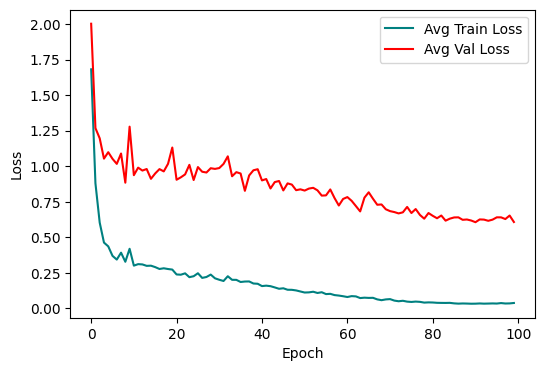

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(clear_train_loss_list, color='teal', label='Avg Train Loss')
plt.plot(clear_val_loss_list, color='red', label='Avg Val Loss')
#plt.title(f'Loss for AlexNet trained on Toybox (instance-level) with Clear Images')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

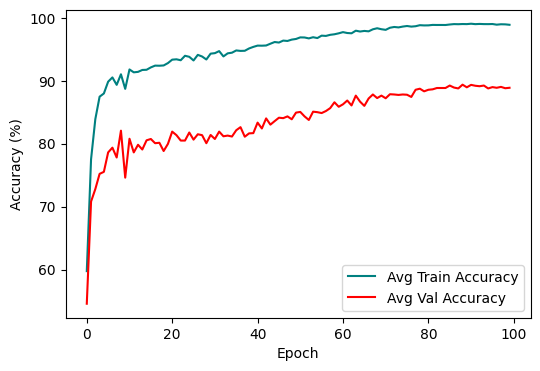

In [6]:
plt.figure(figsize=(6, 4))
plt.plot(clear_train_correct, color='teal', label='Avg Train Accuracy')
plt.plot(clear_val_correct, color='red', label='Avg Val Accuracy')
#plt.title(f'Accuracy for AlexNet trained on Toybox (instance-level) with Clear Images')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

### Plot blurry-to-clear loss and accuracy

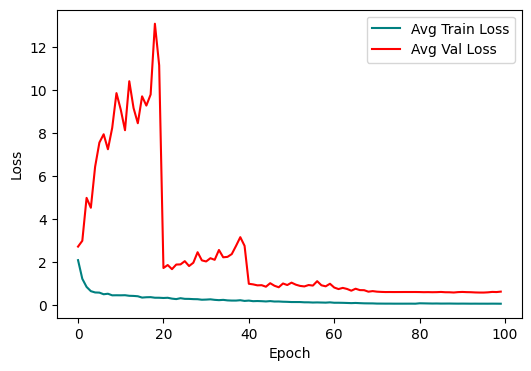

In [7]:
plt.figure(figsize=(6, 4))
plt.plot(blur_train_loss_list, color='teal', label='Avg Train Loss')
plt.plot(blur_val_loss_list, color='red', label='Avg Val Loss')
#plt.title(f'Loss for AlexNet trained on Toybox (instance-level) Blurry-to-clear Sequence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

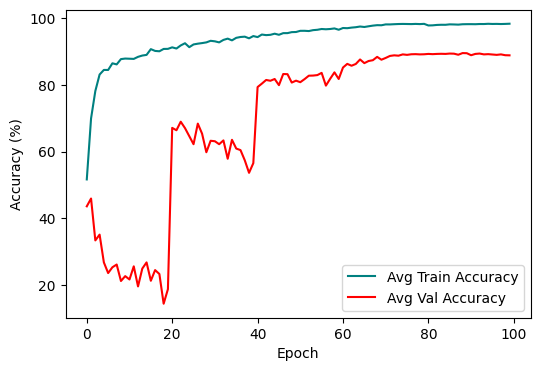

In [8]:
plt.figure(figsize=(6, 4))
plt.plot(blur_train_correct, color='teal', label='Avg Train Accuracy')
plt.plot(blur_val_correct, color='red', label='Avg Val Accuracy')
#plt.title(f'Accuracy for AlexNet trained on Toybox (instance-level) Blurry-to-clear Sequence')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# Full blur training

In [ ]:
epochs = 50
learning_rate = 0.001
batch_size = 256
output_dir = "/content/drive/MyDrive/ug-project/output/alexnet/full_blur/toybox360_full_blur"

os.makedirs(output_dir, exist_ok=True)

In [ ]:
import torch
import torch.nn as nn
from model import AlexNetSup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

blur_model = AlexNetSup(num_classes=360).to(device)

criterion = nn.CrossEntropyLoss()
blur_optimizer = torch.optim.Adam(blur_model.parameters(), lr=learning_rate, weight_decay=1e-5)
steps = len(train_loader)

blur_warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=blur_optimizer, start_factor=0.01, end_factor=1.0,
                                                      total_iters=2*steps)
blur_decay_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=blur_optimizer, T_max=(epochs - 2) * steps)
blur_combined_scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer=blur_optimizer,
                                                            schedulers=[blur_warmup_scheduler, blur_decay_scheduler],
                                                            milestones=[2*steps+1])

In [ ]:
from utils import add_blur_with

# Initialize metrics for plotting
blur_train_correct, blur_val_correct = [], []
blur_train_loss_list, blur_val_loss_list = [], []
logs = []

blur_model.eval()

# Training metrics initialization
blur_train_corr, total_train = 0, 0
blur_train_loss = 0.0

with torch.no_grad():
    for _, images, labels in train_loader:
        # Apply blur transformation
        images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        images, labels = images.to(device), labels.to(device)

        blur_y_pred = blur_model(images)

        # Calculate loss values
        blur_loss = criterion(blur_y_pred, labels)

        # Accumulate total loss weighted by batch size
        blur_train_loss += blur_loss.item() * labels.size(0)

        # Compute accuracy for current batch
        blur_predicted = torch.max(blur_y_pred.data, 1)[1]
        blur_train_corr += (blur_predicted == labels).sum().item()
        total_train += labels.size(0)

# Average accuracy and loss over all training samples
blur_train_accuracy = (blur_train_corr / total_train) * 100
blur_train_loss /= total_train

# Validation metrics initialization
blur_val_corr, total_val = 0, 0
blur_val_loss = 0.0

with torch.no_grad():
    for _, images, labels in val_loader:
        images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        images, labels = images.to(device), labels.to(device)

        # Get predictions from both models on validation data
        blur_y_val_pred = blur_model(images)

        # Calculate loss values for validation set
        blur_loss = criterion(blur_y_val_pred, labels)

        # Accumulate total loss weighted by batch size
        blur_val_loss += blur_loss.item() * labels.size(0)

        # Compute accuracy for current batch
        blur_predicted = torch.max(blur_y_val_pred.data, 1)[1]
        blur_val_corr += (blur_predicted == labels).sum().item()
        total_val += labels.size(0)

# Average accuracy and loss over all validation samples
blur_val_accuracy = (blur_val_corr / total_val) * 100
blur_val_loss /= total_val

# Save results for plotting
blur_train_correct.append(blur_train_accuracy)
blur_val_correct.append(blur_val_accuracy)
blur_train_loss_list.append(blur_train_loss)
blur_val_loss_list.append(blur_val_loss)

blur_log_entry = (f"Epoch 0/{epochs}, Train acc: {blur_train_accuracy:.4f}%, Train loss: {blur_train_loss:.4f}, Val acc: {blur_val_accuracy:.2f}%, Val loss: {blur_val_loss:.4f}")
print(blur_log_entry)
logs.append(blur_log_entry)

Epoch 0/50, Train acc: 0.3397%, Train loss: 5.8890, Val acc: 0.50%, Val loss: 5.8875


### Training loop

In [ ]:
for epoch in range(0, epochs):

    ###################### Train model #########################
    blur_model.train()
    # Initialize accumulators for training loss and sample count
    blur_train_loss_sum = 0.0
    train_samples = 0

    for _, images, labels in train_loader:
        images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        blur_optimizer.zero_grad()

        # Forward passes
        blur_logits = blur_model(images)

        # Compute losses
        blur_loss = criterion(blur_logits, labels)

        # Backward passes and optimizer steps
        blur_loss.backward()
        blur_optimizer.step()
        blur_combined_scheduler.step()

        # Accumulate training loss (weighted by batch size)
        batch_size = labels.size(0)
        blur_train_loss_sum += blur_loss.item() * batch_size
        train_samples += batch_size

    # Compute average training loss over all batches for the training loop
    blur_train_loss_epoch = blur_train_loss_sum / train_samples

    ###################### Evaluate on Training Set ######################
    blur_model.eval()
    blur_train_corr, total_train = 0, 0
    blur_train_loss_eval = 0.0

    with torch.no_grad():
        for _, images, labels in train_loader:
            images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
            images, labels = images.to(device), labels.to(device)

            blur_y_pred = blur_model(images)

            # Calculate loss on the training set (evaluation mode)
            blur_loss_eval = criterion(blur_y_pred, labels)
            batch_size = labels.size(0)
            blur_train_loss_eval += blur_loss_eval.item() * batch_size

            # Compute predictions for accuracy
            blur_predicted = torch.max(blur_y_pred.data, 1)[1]
            blur_train_corr += (blur_predicted == labels).sum().item()
            total_train += batch_size

    blur_train_accuracy = (blur_train_corr / total_train) * 100
    blur_train_loss_avg = blur_train_loss_eval / total_train

    ###################### Evaluate on Validation Set ######################
    blur_val_corr, total_val = 0, 0
    blur_val_loss_sum = 0.0

    with torch.no_grad():
        for _, images, labels in val_loader:
            images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
            images, labels = images.to(device), labels.to(device)

            blur_y_pred = blur_model(images)

            # Compute validation losses
            blur_loss_val = criterion(blur_y_pred, labels)
            batch_size = labels.size(0)
            blur_val_loss_sum += blur_loss_val.item() * batch_size

            # Compute predictions for accuracy
            blur_predicted = torch.max(blur_y_pred.data, 1)[1]
            blur_val_corr += (blur_predicted == labels).sum().item()
            total_val += batch_size

    blur_val_accuracy = (blur_val_corr / total_val) * 100
    blur_val_loss_avg = blur_val_loss_sum / total_val

    # Append losses to loss lists for plotting
    blur_train_loss_list.append(blur_train_loss_avg)
    blur_val_loss_list.append(blur_val_loss_avg)

    # Save accuracy metrics for plotting (accuracy lists defined earlier)
    blur_train_correct.append(blur_train_accuracy)
    blur_val_correct.append(blur_val_accuracy)

    blur_log_entry = (f"Epoch {epoch+1}/{epochs}, Train acc: {blur_train_accuracy:.4f}%, Train loss: {blur_train_loss_avg:.4f}, Val acc: {blur_val_accuracy:.2f}%, Val loss: {blur_val_loss_avg:.4f}")
    print(blur_log_entry)
    logs.append(blur_log_entry)

    ###################### Save Checkpoints ######################
    if (epoch+1) % 10 == 0:
        blur_checkpoint_path = os.path.join(output_dir, f'model_checkpoint_epoch{epoch+1}.pth')
        checkpoint_blur = {
            'epoch': epoch+1,
            'model_state_dict': blur_model.state_dict(),
            'optimizer_state_dict': blur_optimizer.state_dict(),
            'train_accuracy': blur_train_accuracy,
            'train_loss': blur_train_loss_epoch,
        }
        torch.save(checkpoint_blur, blur_checkpoint_path)

Epoch 1/50, Train acc: 52.6640%, Train loss: 2.0318, Val acc: 54.65%, Val loss: 1.9680
Epoch 2/50, Train acc: 70.9860%, Train loss: 1.1664, Val acc: 67.83%, Val loss: 1.3442
Epoch 3/50, Train acc: 78.7476%, Train loss: 0.8355, Val acc: 72.69%, Val loss: 1.1480
Epoch 4/50, Train acc: 82.9360%, Train loss: 0.6535, Val acc: 74.68%, Val loss: 1.1266
Epoch 5/50, Train acc: 84.8217%, Train loss: 0.5717, Val acc: 76.03%, Val loss: 1.0349
Epoch 6/50, Train acc: 86.0393%, Train loss: 0.5283, Val acc: 77.24%, Val loss: 1.0903
Epoch 7/50, Train acc: 87.0682%, Train loss: 0.4804, Val acc: 77.56%, Val loss: 1.0097
Epoch 8/50, Train acc: 87.8816%, Train loss: 0.4575, Val acc: 78.52%, Val loss: 0.9977
Epoch 9/50, Train acc: 89.6133%, Train loss: 0.3874, Val acc: 78.80%, Val loss: 0.9676
Epoch 10/50, Train acc: 89.4501%, Train loss: 0.3989, Val acc: 80.11%, Val loss: 0.9555
Epoch 11/50, Train acc: 89.0266%, Train loss: 0.4041, Val acc: 77.45%, Val loss: 0.9493
Epoch 12/50, Train acc: 89.8976%, Train l

### Save logs to a txt file

In [ ]:
import pickle

with open(f"{output_dir}/training_log.txt", 'w') as log_file:
    for log_entry in logs:
        log_file.write(log_entry + '\n')

blur_metrics = {
    'blur_train_correct': blur_train_correct,
    'blur_val_correct': blur_val_correct,
    'blur_train_loss_list': blur_train_loss_list,
    'blur_val_loss_list': blur_val_loss_list
}

with open(f"{output_dir}/metrics.pkl", "wb") as metrics_file:
    pickle.dump(blur_metrics, metrics_file)

### Plot loss and accuracy

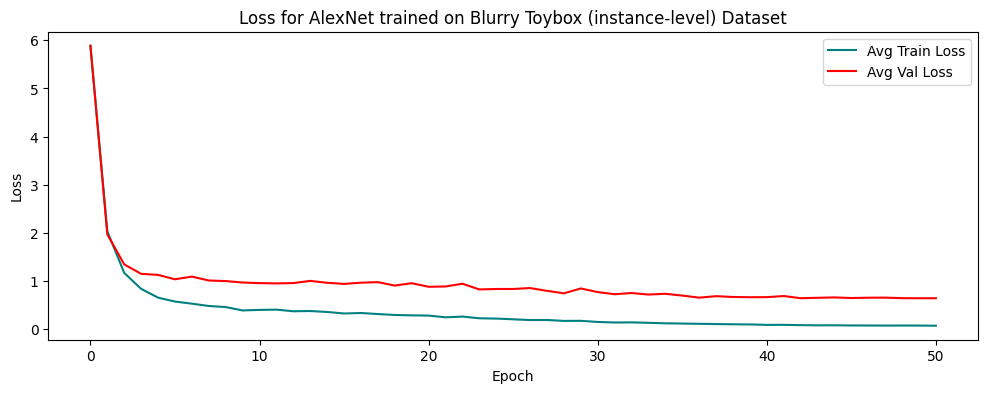

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(blur_train_loss_list, color='teal', label='Avg Train Loss')
plt.plot(blur_val_loss_list, color='red', label='Avg Val Loss')
plt.title(f'Loss for AlexNet trained on Blurry Toybox (instance-level) Dataset')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

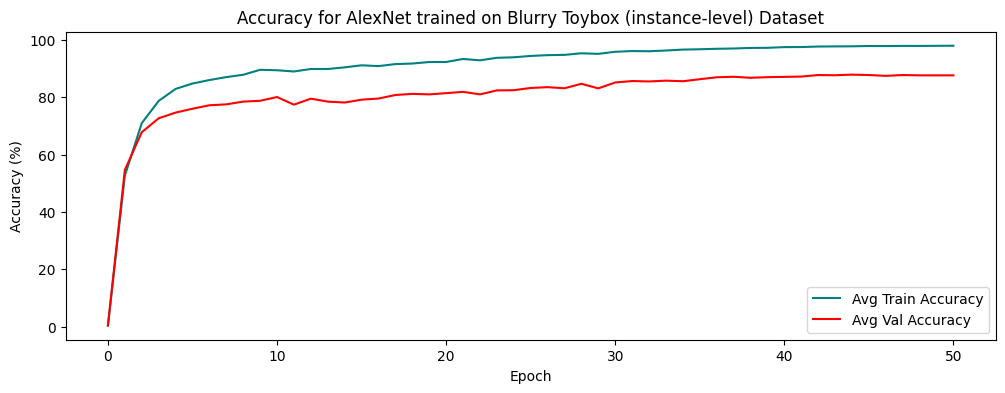

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(blur_train_correct, color='teal', label='Avg Train Accuracy')
plt.plot(blur_val_correct, color='red', label='Avg Val Accuracy')
plt.title(f'Accuracy for AlexNet trained on Blurry Toybox (instance-level) Dataset')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# Continue full blur training 100 epochs

In [ ]:
epochs = 100
learning_rate = 0.001
batch_size = 256
output_dir = "/content/drive/MyDrive/ug-project/output/alexnet/full_blur/toybox360_full_blur"

os.makedirs(output_dir, exist_ok=True)

In [ ]:
import torch
import torch.nn as nn
from model import AlexNetSup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

blur_model = AlexNetSup(num_classes=360).to(device)

criterion = nn.CrossEntropyLoss()
blur_optimizer = torch.optim.Adam(blur_model.parameters(), lr=learning_rate, weight_decay=1e-5)
steps = len(train_loader)

blur_warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=blur_optimizer, start_factor=0.01, end_factor=1.0,
                                                      total_iters=2*steps)
blur_decay_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=blur_optimizer, T_max=(epochs - 2) * steps)
blur_combined_scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer=blur_optimizer,
                                                            schedulers=[blur_warmup_scheduler, blur_decay_scheduler],
                                                            milestones=[2*steps+1])

In [ ]:
import re

text = """
Epoch 0/50, Train acc: 0.3397%, Train loss: 5.8890, Val acc: 0.50%, Val loss: 5.8875
Epoch 1/50, Train acc: 52.6640%, Train loss: 2.0318, Val acc: 54.65%, Val loss: 1.9680
Epoch 2/50, Train acc: 70.9860%, Train loss: 1.1664, Val acc: 67.83%, Val loss: 1.3442
Epoch 3/50, Train acc: 78.7476%, Train loss: 0.8355, Val acc: 72.69%, Val loss: 1.1480
Epoch 4/50, Train acc: 82.9360%, Train loss: 0.6535, Val acc: 74.68%, Val loss: 1.1266
Epoch 5/50, Train acc: 84.8217%, Train loss: 0.5717, Val acc: 76.03%, Val loss: 1.0349
Epoch 6/50, Train acc: 86.0393%, Train loss: 0.5283, Val acc: 77.24%, Val loss: 1.0903
Epoch 7/50, Train acc: 87.0682%, Train loss: 0.4804, Val acc: 77.56%, Val loss: 1.0097
Epoch 8/50, Train acc: 87.8816%, Train loss: 0.4575, Val acc: 78.52%, Val loss: 0.9977
Epoch 9/50, Train acc: 89.6133%, Train loss: 0.3874, Val acc: 78.80%, Val loss: 0.9676
Epoch 10/50, Train acc: 89.4501%, Train loss: 0.3989, Val acc: 80.11%, Val loss: 0.9555
Epoch 11/50, Train acc: 89.0266%, Train loss: 0.4041, Val acc: 77.45%, Val loss: 0.9493
Epoch 12/50, Train acc: 89.8976%, Train loss: 0.3702, Val acc: 79.55%, Val loss: 0.9563
Epoch 13/50, Train acc: 89.8827%, Train loss: 0.3757, Val acc: 78.52%, Val loss: 1.0016
Epoch 14/50, Train acc: 90.4656%, Train loss: 0.3555, Val acc: 78.20%, Val loss: 0.9620
Epoch 15/50, Train acc: 91.1840%, Train loss: 0.3242, Val acc: 79.19%, Val loss: 0.9390
Epoch 16/50, Train acc: 90.9004%, Train loss: 0.3339, Val acc: 79.58%, Val loss: 0.9643
Epoch 17/50, Train acc: 91.6016%, Train loss: 0.3126, Val acc: 80.82%, Val loss: 0.9755
Epoch 18/50, Train acc: 91.7984%, Train loss: 0.2933, Val acc: 81.21%, Val loss: 0.9040
Epoch 19/50, Train acc: 92.3222%, Train loss: 0.2854, Val acc: 81.04%, Val loss: 0.9538
Epoch 20/50, Train acc: 92.3357%, Train loss: 0.2804, Val acc: 81.46%, Val loss: 0.8793
Epoch 21/50, Train acc: 93.3893%, Train loss: 0.2451, Val acc: 81.92%, Val loss: 0.8856
Epoch 22/50, Train acc: 92.9164%, Train loss: 0.2596, Val acc: 81.04%, Val loss: 0.9422
Epoch 23/50, Train acc: 93.7897%, Train loss: 0.2246, Val acc: 82.42%, Val loss: 0.8242
Epoch 24/50, Train acc: 93.9797%, Train loss: 0.2184, Val acc: 82.49%, Val loss: 0.8332
Epoch 25/50, Train acc: 94.4415%, Train loss: 0.2036, Val acc: 83.27%, Val loss: 0.8333
Epoch 26/50, Train acc: 94.7281%, Train loss: 0.1878, Val acc: 83.56%, Val loss: 0.8527
Epoch 27/50, Train acc: 94.8194%, Train loss: 0.1888, Val acc: 83.17%, Val loss: 0.7947
Epoch 28/50, Train acc: 95.3776%, Train loss: 0.1700, Val acc: 84.73%, Val loss: 0.7433
Epoch 29/50, Train acc: 95.1786%, Train loss: 0.1718, Val acc: 83.13%, Val loss: 0.8441
Epoch 30/50, Train acc: 95.8954%, Train loss: 0.1481, Val acc: 85.19%, Val loss: 0.7693
Epoch 31/50, Train acc: 96.1514%, Train loss: 0.1369, Val acc: 85.69%, Val loss: 0.7244
Epoch 32/50, Train acc: 96.0788%, Train loss: 0.1397, Val acc: 85.55%, Val loss: 0.7497
Epoch 33/50, Train acc: 96.3362%, Train loss: 0.1302, Val acc: 85.83%, Val loss: 0.7176
Epoch 34/50, Train acc: 96.6617%, Train loss: 0.1202, Val acc: 85.62%, Val loss: 0.7337
Epoch 35/50, Train acc: 96.7710%, Train loss: 0.1147, Val acc: 86.33%, Val loss: 0.6966
Epoch 36/50, Train acc: 96.9446%, Train loss: 0.1098, Val acc: 87.00%, Val loss: 0.6532
Epoch 37/50, Train acc: 97.0366%, Train loss: 0.1045, Val acc: 87.18%, Val loss: 0.6838
Epoch 38/50, Train acc: 97.2394%, Train loss: 0.0995, Val acc: 86.83%, Val loss: 0.6672
Epoch 39/50, Train acc: 97.2806%, Train loss: 0.0968, Val acc: 87.04%, Val loss: 0.6626
Epoch 40/50, Train acc: 97.5260%, Train loss: 0.0875, Val acc: 87.14%, Val loss: 0.6638
Epoch 41/50, Train acc: 97.5485%, Train loss: 0.0884, Val acc: 87.25%, Val loss: 0.6870
Epoch 42/50, Train acc: 97.7296%, Train loss: 0.0818, Val acc: 87.78%, Val loss: 0.6419
Epoch 43/50, Train acc: 97.7752%, Train loss: 0.0780, Val acc: 87.71%, Val loss: 0.6502
Epoch 44/50, Train acc: 97.8037%, Train loss: 0.0786, Val acc: 87.93%, Val loss: 0.6580
Epoch 45/50, Train acc: 97.9152%, Train loss: 0.0753, Val acc: 87.78%, Val loss: 0.6456
Epoch 46/50, Train acc: 97.8965%, Train loss: 0.0745, Val acc: 87.50%, Val loss: 0.6521
Epoch 47/50, Train acc: 97.9496%, Train loss: 0.0728, Val acc: 87.78%, Val loss: 0.6540
Epoch 48/50, Train acc: 97.9354%, Train loss: 0.0738, Val acc: 87.68%, Val loss: 0.6425
Epoch 49/50, Train acc: 97.9758%, Train loss: 0.0730, Val acc: 87.68%, Val loss: 0.6408
Epoch 50/50, Train acc: 98.0110%, Train loss: 0.0699, Val acc: 87.68%, Val loss: 0.6413
"""

pattern_blur = r"Train acc: ([\d.]+)%, Train loss: ([\d.]+), Val acc: ([\d.]+)%, Val loss: ([\d.]+)"
blur_data = re.findall(pattern_blur, text)

blur_train_correct = [float(acc) for acc, _, _, _ in blur_data]
blur_train_loss_list = [float(loss) for _, loss, _, _ in blur_data]
blur_val_correct = [float(val_acc) for _, _, val_acc, _ in blur_data]
blur_val_loss_list = [float(val_loss) for _, _, _, val_loss in blur_data]

# Split the text into individual lines
logs = text.strip().split("\n")

In [ ]:
import os
import torch
from utils import add_blur_with

resume_epoch = 50
blur_checkpoint_path = os.path.join(output_dir, f'model_checkpoint_epoch{resume_epoch}.pth')

if os.path.exists(blur_checkpoint_path):
    print(f"Loading checkpoint from epoch {resume_epoch}...")
    blur_checkpoint = torch.load(blur_checkpoint_path, map_location=device)

    # Load model and optimizer states
    blur_model.load_state_dict(blur_checkpoint['model_state_dict'])
    blur_optimizer.load_state_dict(blur_checkpoint['optimizer_state_dict'])

    # Restore scheduler state if available; otherwise, you could fall back to manual stepping.
    if 'lr_scheduler_state_dict' in blur_checkpoint:
        blur_combined_scheduler.load_state_dict(blur_checkpoint['lr_scheduler_state_dict'])
    else:
        # Manual stepping fallback (not recommended)
        for _ in range(resume_epoch * len(train_loader)):
            blur_combined_scheduler.step()

    # Update starting epoch from the checkpoint
    start_epoch = blur_checkpoint.get('epoch', resume_epoch)
    print(f"Successfully resumed training from epoch {start_epoch}.")
else:
    print("Checkpoint not found, starting from scratch.")
    start_epoch = 0

# Set model to evaluation mode to verify weights are loaded correctly
blur_model.eval()

# Run a quick validation check
blur_val_corr, total_val = 0, 0
with torch.no_grad():
    for _, images, labels in val_loader:
        images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        images, labels = images.to(device), labels.to(device)
        blur_pred = blur_model(images)
        blur_predicted = torch.max(blur_pred, 1)[1]
        blur_val_corr += (blur_predicted == labels).sum().item()
        total_val += labels.size(0)

blur_val_acc = (blur_val_corr / total_val) * 100
print(f"Validation Accuracy after checkpoint load - Blur Model: {blur_val_acc:.2f}%")

Loading checkpoint from epoch 50...
Successfully resumed training from epoch 50.
Validation Accuracy after checkpoint load - Blur Model: 87.68%


In [ ]:
for epoch in range(resume_epoch, epochs):

    ###################### Train model #########################
    blur_model.train()
    # Initialize accumulators for training loss and sample count
    blur_train_loss_sum = 0.0
    train_samples = 0

    for _, images, labels in train_loader:
        images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        blur_optimizer.zero_grad()

        # Forward passes
        blur_logits = blur_model(images)

        # Compute losses
        blur_loss = criterion(blur_logits, labels)

        # Backward passes and optimizer steps
        blur_loss.backward()
        blur_optimizer.step()
        blur_combined_scheduler.step()

        # Accumulate training loss (weighted by batch size)
        batch_size = labels.size(0)
        blur_train_loss_sum += blur_loss.item() * batch_size
        train_samples += batch_size

    # Compute average training loss over all batches for the training loop
    blur_train_loss_epoch = blur_train_loss_sum / train_samples

    ###################### Evaluate on Training Set ######################
    blur_model.eval()
    blur_train_corr, total_train = 0, 0
    blur_train_loss_eval = 0.0

    with torch.no_grad():
        for _, images, labels in train_loader:
            images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
            images, labels = images.to(device), labels.to(device)

            blur_y_pred = blur_model(images)

            # Calculate loss on the training set (evaluation mode)
            blur_loss_eval = criterion(blur_y_pred, labels)
            batch_size = labels.size(0)
            blur_train_loss_eval += blur_loss_eval.item() * batch_size

            # Compute predictions for accuracy
            blur_predicted = torch.max(blur_y_pred.data, 1)[1]
            blur_train_corr += (blur_predicted == labels).sum().item()
            total_train += batch_size

    blur_train_accuracy = (blur_train_corr / total_train) * 100
    blur_train_loss_avg = blur_train_loss_eval / total_train

    ###################### Evaluate on Validation Set ######################
    blur_val_corr, total_val = 0, 0
    blur_val_loss_sum = 0.0

    with torch.no_grad():
        for _, images, labels in val_loader:
            images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
            images, labels = images.to(device), labels.to(device)

            blur_y_pred = blur_model(images)

            # Compute validation losses
            blur_loss_val = criterion(blur_y_pred, labels)
            batch_size = labels.size(0)
            blur_val_loss_sum += blur_loss_val.item() * batch_size

            # Compute predictions for accuracy
            blur_predicted = torch.max(blur_y_pred.data, 1)[1]
            blur_val_corr += (blur_predicted == labels).sum().item()
            total_val += batch_size

    blur_val_accuracy = (blur_val_corr / total_val) * 100
    blur_val_loss_avg = blur_val_loss_sum / total_val

    # Append losses to loss lists for plotting
    blur_train_loss_list.append(blur_train_loss_avg)
    blur_val_loss_list.append(blur_val_loss_avg)

    # Save accuracy metrics for plotting (accuracy lists defined earlier)
    blur_train_correct.append(blur_train_accuracy)
    blur_val_correct.append(blur_val_accuracy)

    blur_log_entry = (f"Epoch {epoch+1}/{epochs}, Train acc: {blur_train_accuracy:.4f}%, Train loss: {blur_train_loss_avg:.4f}, Val acc: {blur_val_accuracy:.2f}%, Val loss: {blur_val_loss_avg:.4f}")
    print(blur_log_entry)
    logs.append(blur_log_entry)

    ###################### Save Checkpoints ######################
    if (epoch+1) % 10 == 0:
        blur_checkpoint_path = os.path.join(output_dir, f'model_checkpoint_epoch{epoch+1}.pth')
        checkpoint_blur = {
            'epoch': epoch+1,
            'model_state_dict': blur_model.state_dict(),
            'optimizer_state_dict': blur_optimizer.state_dict(),
            'scheduler_state_dict': blur_combined_scheduler.state_dict(),
            'train_accuracy': blur_train_accuracy,
            'train_loss': blur_train_loss_epoch,
        }
        torch.save(checkpoint_blur, blur_checkpoint_path)

Epoch 51/100, Train acc: 97.9204%, Train loss: 0.0739, Val acc: 87.78%, Val loss: 0.6405
Epoch 52/100, Train acc: 97.9421%, Train loss: 0.0731, Val acc: 87.75%, Val loss: 0.6391
Epoch 53/100, Train acc: 97.9331%, Train loss: 0.0712, Val acc: 87.86%, Val loss: 0.6448
Epoch 54/100, Train acc: 97.9256%, Train loss: 0.0733, Val acc: 87.64%, Val loss: 0.6439
Epoch 55/100, Train acc: 97.9728%, Train loss: 0.0724, Val acc: 87.96%, Val loss: 0.6433
Epoch 56/100, Train acc: 97.9773%, Train loss: 0.0716, Val acc: 87.86%, Val loss: 0.6400
Epoch 57/100, Train acc: 97.8830%, Train loss: 0.0751, Val acc: 87.89%, Val loss: 0.6541
Epoch 58/100, Train acc: 97.9234%, Train loss: 0.0738, Val acc: 87.86%, Val loss: 0.6481
Epoch 59/100, Train acc: 97.8770%, Train loss: 0.0756, Val acc: 87.36%, Val loss: 0.6383
Epoch 60/100, Train acc: 97.7648%, Train loss: 0.0784, Val acc: 87.64%, Val loss: 0.6488
Epoch 61/100, Train acc: 97.7962%, Train loss: 0.0778, Val acc: 87.46%, Val loss: 0.6747
Epoch 62/100, Train a

### Save logs to a txt file

In [ ]:
import pickle

with open(f"{output_dir}/training_log.txt", 'w') as log_file:
    for log_entry in logs:
        log_file.write(log_entry + '\n')

blur_metrics = {
    'blur_train_correct': blur_train_correct,
    'blur_val_correct': blur_val_correct,
    'blur_train_loss_list': blur_train_loss_list,
    'blur_val_loss_list': blur_val_loss_list
}

with open(f"{output_dir}/metrics.pkl", "wb") as metrics_file:
    pickle.dump(blur_metrics, metrics_file)

### Plot loss and accuracy

In [9]:
import pickle

output_dir_blur = "/content/drive/MyDrive/ug-project/output/alexnet/full_blur/toybox360_full_blur"

with open(f"{output_dir_blur}/metrics.pkl", "rb") as metrics_file:
    blur_metrics = pickle.load(metrics_file)

blur_train_correct = blur_metrics['blur_train_correct']
blur_val_correct = blur_metrics['blur_val_correct']
blur_train_loss_list = blur_metrics['blur_train_loss_list']
blur_val_loss_list = blur_metrics['blur_val_loss_list']

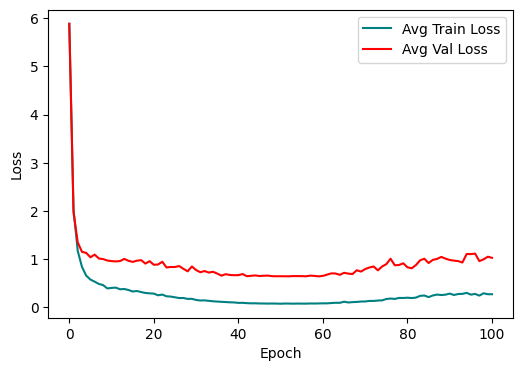

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(blur_train_loss_list, color='teal', label='Avg Train Loss')
plt.plot(blur_val_loss_list, color='red', label='Avg Val Loss')
#plt.title(f'Loss for AlexNet trained on Blurry Toybox (instance-level) Dataset')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

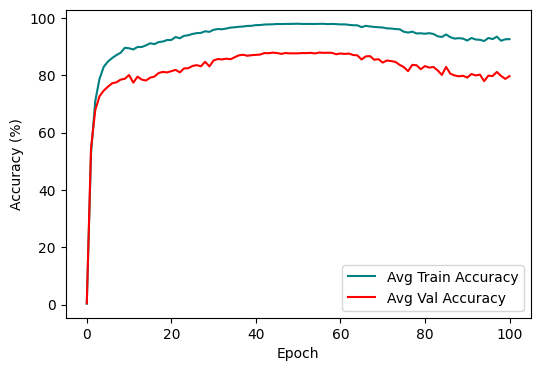

In [13]:
plt.figure(figsize=(6, 4))
plt.plot(blur_train_correct, color='teal', label='Avg Train Accuracy')
plt.plot(blur_val_correct, color='red', label='Avg Val Accuracy')
#plt.title(f'Accuracy for AlexNet trained on Blurry Toybox (instance-level) Dataset')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()